In [ ]:
#필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from shapely.geometry import Point, Polygon, LineString
from fiona.crs import from_string

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/BigContest/전처리_코드정리/

/content/drive/MyDrive/BigContest/전처리_코드정리


## 1. 대학교 포함여부

In [ ]:
college = gpd.read_file('서울시 대학교 공간데이터/2020/TL_UNIV_2020.shp', encoding = 'cp949')
college = college[college['ELSM'] != '대학원']
college = college[college['UNIV_STTUS'] != '폐교']

seoul_pnu = gpd.read_file('서울시_필지_LX맵/서울시_필지전체.shp', encoding = 'cp949')
seoul_pnu = seoul_pnu.astype({'PNU' : 'int'})

raw_df = pd.read_csv('필지단위 소상공인 매출등급 정보.csv', encoding = 'cp949')
test = pd.read_excel('소상공인 매출등급 예상 대상 필지.xlsx')

In [ ]:
# train이면 1, test면 0 변수 생성
raw_df['train'] = 1

# test 데이터는 202301과 202302가 열별로 되어있어 각각 데이터프레임 만든 후 raw데이터 밑으로 붙이기
test_2301 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2302 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2301['DATA_CRTR_YM'] = 202301
test_2302['DATA_CRTR_YM'] = 202302
test_2301['train'] = 0
test_2302['train'] = 0

test_2301 = test_2301[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'train']]
test_2302 = test_2302[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'train']]

raw_df = pd.concat([raw_df, test_2301, test_2302])
temp = raw_df.drop_duplicates(subset = 'LT_UNQ_NO', keep = 'first', ignore_index = True)
temp = temp[['LT_UNQ_NO']]

<ipython-input-5-6eb114fd7e30>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2301['DATA_CRTR_YM'] = 202301
<ipython-input-5-6eb114fd7e30>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2302['DATA_CRTR_YM'] = 202302


In [ ]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74303 entries, 0 to 74302
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LT_UNQ_NO  74303 non-null  int64
dtypes: int64(1)
memory usage: 580.6 KB


In [ ]:
df = pd.merge(left = seoul_pnu, right = temp, left_on = 'PNU', right_on = 'LT_UNQ_NO', how = 'right')
df.drop(['PNU'], axis = 1, inplace = True)
df = df[['LT_UNQ_NO', 'SGG_CD', 'SGG_NM', 'EMD_CD', 'EMD_NM', 'geometry']]

In [ ]:
df_in_match = df.dropna(axis = 0)
df_notin_match = df[df['geometry'].isna()]

df_in_match 필지가 대학교를 포함하고 있는지 여부

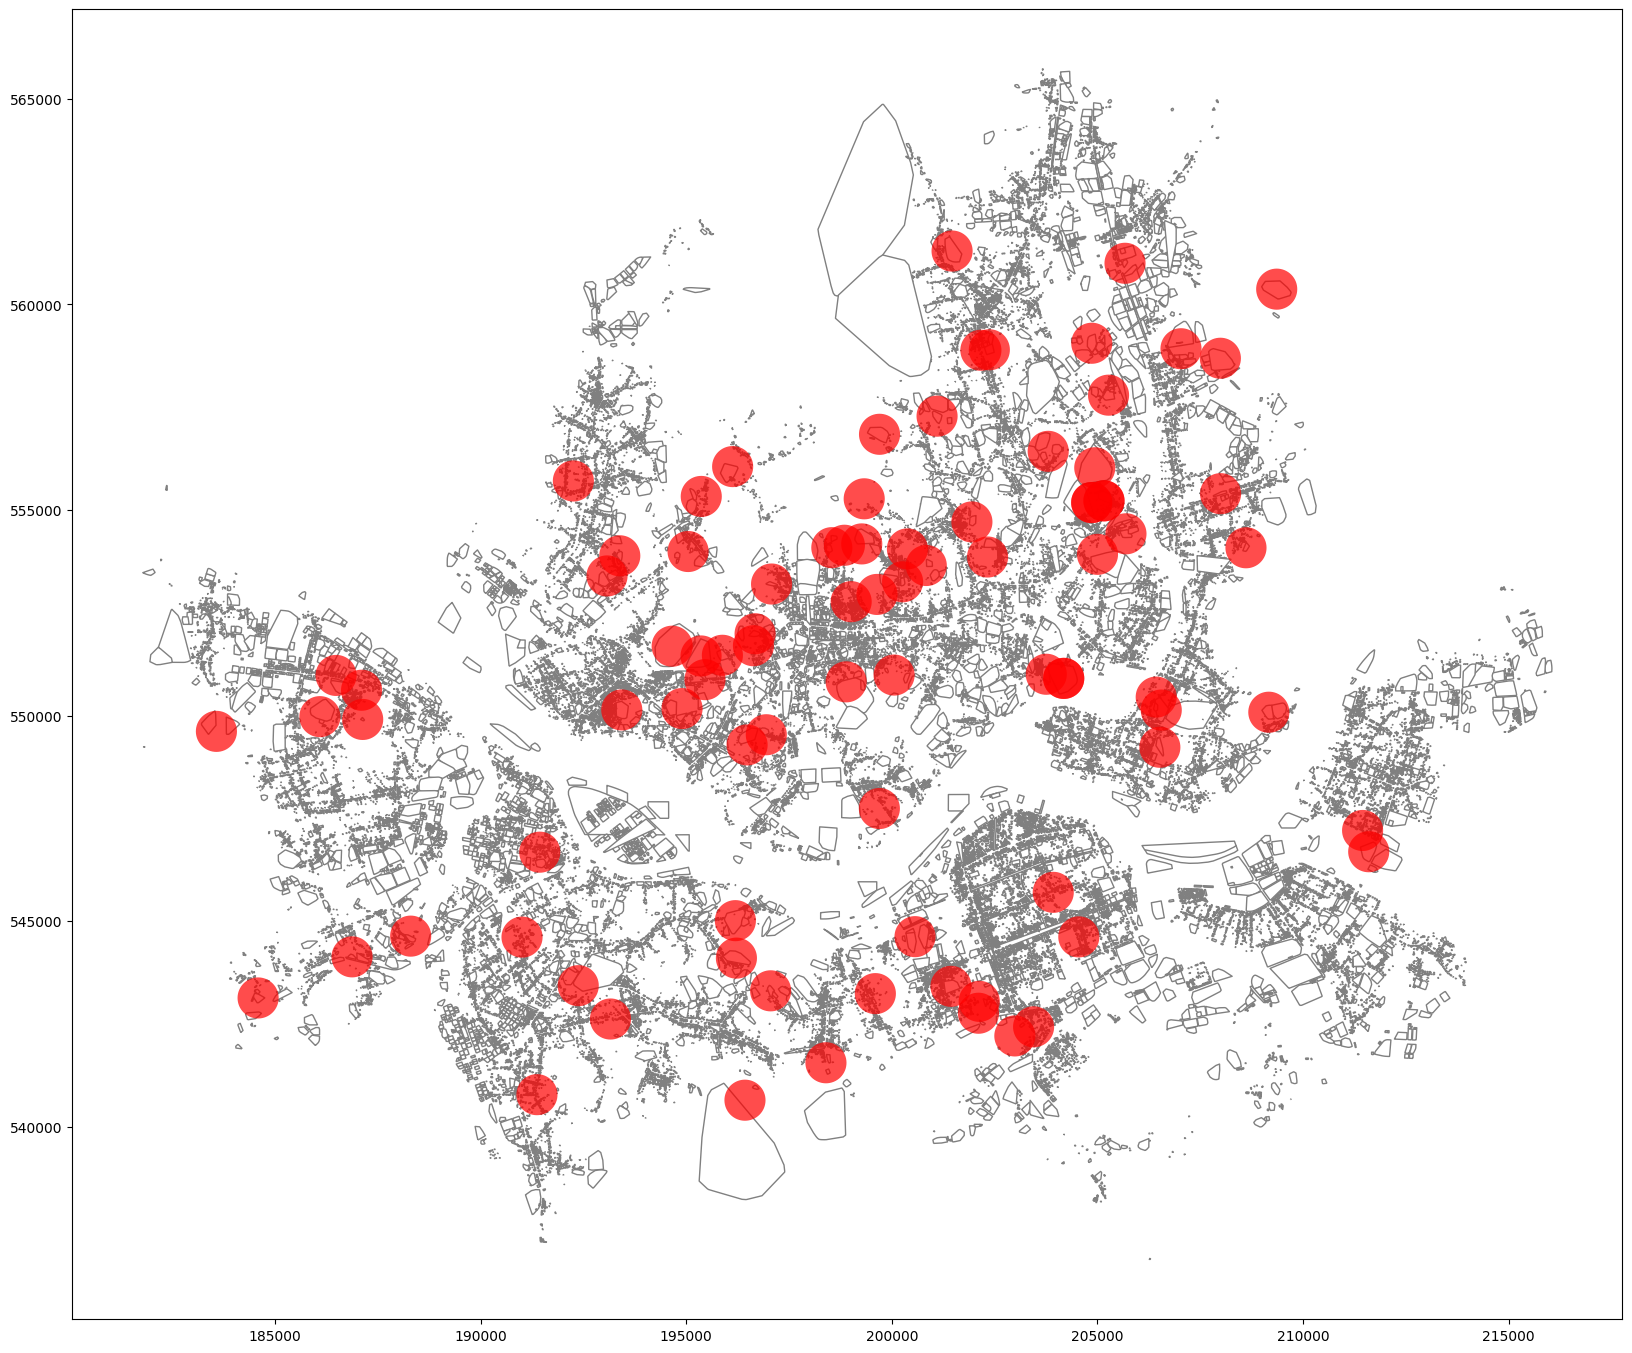

In [ ]:
#대학교 주변을 고려하기 위해 버퍼 500m 설정
college['buffer'] = college.convex_hull.buffer(500)

ax = df_in_match.convex_hull.plot(figsize = (20, 20), color='white', edgecolor='gray')
college['buffer'].convex_hull.plot(ax = ax, color = 'red', alpha = 0.7)
plt.show()

In [ ]:
college_count = pd.DataFrame()
for i in range(len(college)) :
  college_count[str(i)] = df_in_match['geometry'].intersects(college['buffer'].iloc[i])

df_in_match['college_count'] = college_count.sum(axis = 1).apply(lambda x: 1 if x > 0 else 0)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
df2 = df_in_match.drop(df_in_match.columns[1:6], axis = 1)

df_notin_match 필지가 대학교를 포함하고 있는지 여부

In [ ]:
df_notin_match['EMD'] = df_notin_match['LT_UNQ_NO'].apply(lambda x: str(x)[0:8])

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


서울시 법정동 shp 출처 : http://data.nsdi.go.kr/dataset/15145

서울시 법정동 shp 파일과 대학교 shp merge해서 법정동별 대학교 포함 여부 체크

In [ ]:
emd = gpd.read_file('LSMD_ADM_SECT_UMD_서울/LSMD_ADM_SECT_UMD_11_202309.shp', encoding = 'cp949')

college_count2 = pd.DataFrame()
for i in range(len(college)) :
  college_count2[str(i)] = emd['geometry'].intersects(college['buffer'].iloc[i])

emd['college_count'] = college_count2.sum(axis = 1).apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# [서울시 법정동별로 대학교 포함 여부 count한 파일] & [df_notin_data] merge
df_notin_match = pd.merge(left = df_notin_match, right = emd, left_on = 'EMD', right_on = 'EMD_CD', how = 'left')
df_notin_match = df_notin_match[['LT_UNQ_NO', 'college_count']]
df_notin_match

,LT_UNQ_NO,college_count
0,1111011000102450006,1
1,1120010700103770000,1
2,1121510500108610000,1
3,1126010500106150005,1
4,1132010500107340000,1
...,...,...
99,1123010500104750146,0
100,1126010500106160001,1
101,1130510400102410002,1
102,1135010300107580000,1


raw_data와 merge

In [ ]:
college_contain = pd.concat([df2, df_notin_match])
raw_data2 = pd.merge(left = raw_df, right = college_contain, on = 'LT_UNQ_NO', how = 'left')
college_pnu=raw_data2

## 2. 행정동별_노인인구수(65세 이상, 65세 이상 남녀)

In [ ]:
match_data = pd.read_csv('필지번호_행정동1.csv', encoding = 'cp949')

In [ ]:
# 신사동이 관악구, 강남구 둘 다에 속해서 따로 처리해줘야함. 이외에 구는 경계에 걸친 애들
for i in range(len(match_data)):
    if match_data['ADM_NM'][i] == '신사동':
        if (match_data['SGG_NM'][i] == '관악구') or (match_data['SGG_NM'][i] == '동작구'):
            match_data['ADM_NM'][i] = '신사동1'
        elif (match_data['SGG_NM'][i] == '강남구') or (match_data['SGG_NM'][i] == '서초구') or (match_data['SGG_NM'][i] == '용산구')or (match_data['SGG_NM'][i] == '성동구'):
            match_data['ADM_NM'][i] = '신사동2'

<ipython-input-18-0a71b93ad8b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data['ADM_NM'][i] = '신사동2'
<ipython-input-18-0a71b93ad8b6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_data['ADM_NM'][i] = '신사동1'


raw데이터와 매칭 안되는 필지번호는 분리

In [ ]:
X = pd.DataFrame(raw_df['LT_UNQ_NO'].unique())
Y = pd.DataFrame(match_data['PNU'].unique())
PNU_NOTIN_data = pd.DataFrame(set(raw_df['LT_UNQ_NO'].unique())-set(match_data['PNU'].unique()))
PNU_IN_data = pd.DataFrame(set(raw_df['LT_UNQ_NO'].unique()) & set(match_data['PNU'].unique()))
PNU_NOTIN_data.rename(columns={0:'PNU'}, inplace=True)
PNU_IN_data.rename(columns={0:'PNU'}, inplace=True)

In [ ]:
raw_in_match = raw_df[raw_df['LT_UNQ_NO'].isin(PNU_IN_data['PNU'])]
raw_notin_match = raw_df[~raw_df['LT_UNQ_NO'].isin(PNU_IN_data['PNU'])]

In [ ]:
# 데이터에 있는 필지번호와 match를 merge
df = pd.merge(PNU_IN_data, match_data, how='left')

# 중복 필지 중 하나만 남기고 제거
df.drop_duplicates(subset='PNU', keep='first', inplace=True, ignore_index=False)

# raw데이터에 행정동명 합치기
raw_in_match = pd.merge(raw_in_match, df[['PNU', 'ADM_CD', 'ADM_NM']], how='left', left_on = 'LT_UNQ_NO', right_on = 'PNU')
raw_in_match = raw_in_match[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'ADM_CD', 'ADM_NM', 'INDUSTRY_CD', 'SLS_GRD', 'train']]

raw 데이터에 행정동별 노인인구수(65세 이상. 65세 이상 남/녀) 붙이기

In [ ]:
# 행정동별 노인인구수
p2201 = pd.read_csv('행정동별_인구수/202201_202201_연령별인구현황_월간.csv', encoding = 'utf-8')
p2202 = pd.read_csv('행정동별_인구수/202202_202202_연령별인구현황_월간.csv', encoding = 'utf-8')
p2203 = pd.read_csv('행정동별_인구수/202203_202203_연령별인구현황_월간.csv', encoding = 'utf-8')
p2204 = pd.read_csv('행정동별_인구수/202204_202204_연령별인구현황_월간.csv', encoding = 'utf-8')
p2205 = pd.read_csv('행정동별_인구수/202205_202205_연령별인구현황_월간.csv', encoding = 'utf-8')
p2206 = pd.read_csv('행정동별_인구수/202206_202206_연령별인구현황_월간.csv', encoding = 'utf-8')
p2207 = pd.read_csv('행정동별_인구수/202207_202207_연령별인구현황_월간.csv', encoding = 'utf-8')
p2208 = pd.read_csv('행정동별_인구수/202208_202208_연령별인구현황_월간.csv', encoding = 'utf-8')
p2209 = pd.read_csv('행정동별_인구수/202209_202209_연령별인구현황_월간.csv', encoding = 'utf-8')
p2210 = pd.read_csv('행정동별_인구수/202210_202210_연령별인구현황_월간.csv', encoding = 'utf-8')
p2211 = pd.read_csv('행정동별_인구수/202211_202211_연령별인구현황_월간.csv', encoding = 'utf-8')
p2212 = pd.read_csv('행정동별_인구수/202212_202212_연령별인구현황_월간.csv', encoding = 'utf-8')
p2301 = pd.read_csv('행정동별_인구수/202301_202301_연령별인구현황_월간.csv', encoding = 'utf-8')
p2302 = pd.read_csv('행정동별_인구수/202302_202302_연령별인구현황_월간.csv', encoding = 'utf-8')

# 신사동1, 신사동2 구분
data_list = [p2201, p2202, p2203, p2204, p2205, p2206, p2207, p2208, p2209, p2210, p2211, p2212, p2301, p2302]

for i in data_list :
  i.iloc[332, 1] = '관악구 신사동1'
  i.iloc[358, 1] = '강남구 신사동2'

# 행정동별 노인인구수에서 행정구역을 이용해서 행정동 만들기
p2201['ADM_NM'] = p2201['행정기관'].apply(lambda x: x.split()[1])
p2202['ADM_NM'] = p2202['행정기관'].apply(lambda x: x.split()[1])
p2203['ADM_NM'] = p2203['행정기관'].apply(lambda x: x.split()[1])
p2204['ADM_NM'] = p2204['행정기관'].apply(lambda x: x.split()[1])
p2205['ADM_NM'] = p2205['행정기관'].apply(lambda x: x.split()[1])
p2206['ADM_NM'] = p2206['행정기관'].apply(lambda x: x.split()[1])
p2207['ADM_NM'] = p2207['행정기관'].apply(lambda x: x.split()[1])
p2208['ADM_NM'] = p2208['행정기관'].apply(lambda x: x.split()[1])
p2209['ADM_NM'] = p2209['행정기관'].apply(lambda x: x.split()[1])
p2210['ADM_NM'] = p2210['행정기관'].apply(lambda x: x.split()[1])
p2211['ADM_NM'] = p2211['행정기관'].apply(lambda x: x.split()[1])
p2212['ADM_NM'] = p2212['행정기관'].apply(lambda x: x.split()[1])
p2301['ADM_NM'] = p2301['행정기관'].apply(lambda x: x.split()[1])
p2302['ADM_NM'] = p2302['행정기관'].apply(lambda x: x.split()[1])

In [ ]:
p2201.head(2)

,행정기관코드,행정기관,65세이상,65세이상_남,65세이상_여,ADM_NM
0,1111051500,종로구 청운효자동,"2,144",875,"1,269",청운효자동
1,1111053000,종로구 사직동,"1,759",767,992,사직동


In [ ]:
# 월별로 merge
raw_2201 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202201], p2201[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2202 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202202], p2202[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2203 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202203], p2203[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2204 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202204], p2204[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2205 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202205], p2205[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2206 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202206], p2206[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2207 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202207], p2207[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2208 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202208], p2208[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2209 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202209], p2209[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2210 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202210], p2210[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2211 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202211], p2211[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2212 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202212], p2212[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2301 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202301], p2301[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2302 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] == 202302], p2302[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')

# 월별 데이터 하나로 합치기
raw_in_match = pd.concat([raw_2201, raw_2202, raw_2203, raw_2204, raw_2205, raw_2206, raw_2207, raw_2208, raw_2209,
                          raw_2210, raw_2211, raw_2212, raw_2301, raw_2302])
raw_in_match.reset_index(drop = True, inplace = True)

raw_in_match['65세이상'] = raw_in_match['65세이상'].apply(lambda x: int(x.replace(',','')))
raw_in_match['65세이상_남'] = raw_in_match['65세이상_남'].apply(lambda x: int(x.replace(',','')))
raw_in_match['65세이상_여'] = raw_in_match['65세이상_여'].apply(lambda x: int(x.replace(',','')))

In [ ]:
raw_in_match

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,ADM_CD,ADM_NM,INDUSTRY_CD,SLS_GRD,train,65세이상,65세이상_남,65세이상_여
0,202201,1111010100100030100,11110101,11010720,청운효자동,A03,4.0,1,2144,875,1269
1,202201,1111010100100480000,11110101,11010720,청운효자동,A01,2.0,1,2144,875,1269
2,202201,1111010100100590001,11110101,11010720,청운효자동,A11,3.0,1,2144,875,1269
3,202201,1111010100100590005,11110101,11010720,청운효자동,A03,2.0,1,2144,875,1269
4,202201,1111010100100690000,11110101,11010720,청운효자동,A01,2.0,1,2144,875,1269
...,...,...,...,...,...,...,...,...,...,...,...
1172897,202302,1130510100100830004,11305101,11090710,송중동,A03,NaN,0,6234,2748,3486
1172898,202302,1135010300107450000,11350103,11110560,공릉2동,A13,NaN,0,5965,2691,3274
1172899,202302,1150010300103400017,11500103,11160630,화곡8동,A06,NaN,0,4596,2007,2589
1172900,202302,1144012700116070000,11440127,11140740,상암동,A03,NaN,0,4279,1801,2478


raw_notin_match 합치기

In [ ]:
# 필지번호 앞 10자리 기준으로 평균
pnu_match = match_data['PNU'].astype(str)
pnu_notin_match = raw_notin_match['LT_UNQ_NO'].astype(str)

def str_slicing(s):
    return s[:10]

pnu_match_slice = list(map(str_slicing, pnu_match))
pnu_notin_match_slice = list(map(str_slicing, pnu_notin_match))

In [ ]:
set(pnu_notin_match_slice) - set(pnu_match_slice) # 10번째 자리까지 slice하면 match에 있는 필지번호(10자리까지)에 모두 포함됨

set()

In [ ]:
#raw_notin_match에 slicing한 필지번호 추가해서 matching
raw_notin_match['LT_UNQ_NO_slice'] = raw_notin_match['LT_UNQ_NO'].astype(str)
raw_notin_match['LT_UNQ_NO_slice'] = list(map(str_slicing, raw_notin_match['LT_UNQ_NO_slice']))
match_data['PNU_slice'] = match_data['PNU'].astype(str)
match_data['PNU_slice'] = list(map(str_slicing, match_data['PNU_slice']))

<ipython-input-28-b483a7c9356a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_notin_match['LT_UNQ_NO_slice'] = raw_notin_match['LT_UNQ_NO'].astype(str)
<ipython-input-28-b483a7c9356a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_notin_match['LT_UNQ_NO_slice'] = list(map(str_slicing, raw_notin_match['LT_UNQ_NO_slice']))


In [ ]:
raw_notin_match1 = raw_notin_match

match_data.drop(columns='PNU', inplace=True)
match_data.drop_duplicates(inplace=True)

raw_notin_match = pd.merge(raw_notin_match, match_data[['PNU_slice', 'ADM_CD', 'ADM_NM']], left_on='LT_UNQ_NO_slice', right_on='PNU_slice', how = 'left')
raw_notin_match.drop(columns=['PNU_slice'], axis=1, inplace=True)

raw_notin_match = raw_notin_match[['DATA_CRTR_YM', 'LT_UNQ_NO', 'LT_UNQ_NO_slice', 'STDG_EMD_CD', 'ADM_CD', 'ADM_NM', 'INDUSTRY_CD', 'SLS_GRD', 'train']]

In [ ]:
raw_notin_match

,DATA_CRTR_YM,LT_UNQ_NO,LT_UNQ_NO_slice,STDG_EMD_CD,ADM_CD,ADM_NM,INDUSTRY_CD,SLS_GRD,train
0,202201,1111011000102450006,1111011000,11110110,11010720,청운효자동,A03,2.0,1
1,202201,1111011000102450006,1111011000,11110110,11010530,사직동,A03,2.0,1
2,202201,1120010700103770000,1120010700,11200107,11040550,사근동,A01,3.0,1
3,202201,1120010700103770000,1120010700,11200107,11040540,마장동,A01,3.0,1
4,202201,1120010700103770000,1120010700,11200107,11040560,행당1동,A01,3.0,1
...,...,...,...,...,...,...,...,...,...
28329,202302,1171010800106400007,1171010800,11710108,11240530,거여1동,A11,NaN,0
28330,202302,1171010800106400007,1171010800,11710108,11240650,가락본동,A11,NaN,0
28331,202302,1171010800106400007,1171010800,11710108,11240690,문정2동,A11,NaN,0
28332,202302,1171010800106400007,1171010800,11710108,11240660,가락1동,A11,NaN,0


In [ ]:
pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202201], p2201[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')

,DATA_CRTR_YM,LT_UNQ_NO,LT_UNQ_NO_slice,STDG_EMD_CD,ADM_CD,ADM_NM,INDUSTRY_CD,SLS_GRD,train,65세이상,65세이상_남,65세이상_여
0,202201,1111011000102450006,1111011000,11110110,11010720,청운효자동,A03,2.0,1,"2,144",875,"1,269"
1,202201,1111011000102450006,1111011000,11110110,11010530,사직동,A03,2.0,1,"1,759",767,992
2,202201,1120010700103770000,1120010700,11200107,11040550,사근동,A01,3.0,1,"1,509",642,867
3,202201,1120010700103770000,1120010700,11200107,11040540,마장동,A01,3.0,1,"3,944","1,748","2,196"
4,202201,1120010700103770000,1120010700,11200107,11040560,행당1동,A01,3.0,1,"2,143",967,"1,176"
...,...,...,...,...,...,...,...,...,...,...,...,...
2147,202201,1174010300105260000,1174010300,11740103,11250750,강일동,A03,5.0,1,"5,363","2,327","3,036"
2148,202201,1174010300105260000,1174010300,11740103,11250760,상일1동,A03,5.0,1,"4,430","2,138","2,292"
2149,202201,1174010300105260000,1174010300,11740103,11250560,고덕2동,A03,5.0,1,"3,022","1,460","1,562"
2150,202201,1174010300105260000,1174010300,11740103,11250550,고덕1동,A03,5.0,1,"2,871","1,318","1,553"


In [ ]:
# 월별로 merge
raw_2201 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202201], p2201[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2202 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202202], p2202[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2203 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202203], p2203[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2204 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202204], p2204[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2205 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202205], p2205[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2206 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202206], p2206[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2207 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202207], p2207[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2208 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202208], p2208[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2209 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202209], p2209[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2210 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202210], p2210[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2211 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202211], p2211[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2212 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202212], p2212[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2301 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202301], p2301[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')
raw_2302 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] == 202302], p2302[['ADM_NM', '65세이상', '65세이상_남', '65세이상_여']], how = 'left', on = 'ADM_NM')

# 월별 데이터 하나로 합치기
raw_notin_match = pd.concat([raw_2201, raw_2202, raw_2203, raw_2204, raw_2205, raw_2206, raw_2207, raw_2208, raw_2209,
                             raw_2210, raw_2211, raw_2212, raw_2301, raw_2302])
raw_notin_match.reset_index(drop = True, inplace = True)

In [ ]:
raw_notin_match

,DATA_CRTR_YM,LT_UNQ_NO,LT_UNQ_NO_slice,STDG_EMD_CD,ADM_CD,ADM_NM,INDUSTRY_CD,SLS_GRD,train,65세이상,65세이상_남,65세이상_여
0,202201,1111011000102450006,1111011000,11110110,11010720,청운효자동,A03,2.0,1,"2,144",875,"1,269"
1,202201,1111011000102450006,1111011000,11110110,11010530,사직동,A03,2.0,1,"1,759",767,992
2,202201,1120010700103770000,1120010700,11200107,11040550,사근동,A01,3.0,1,"1,509",642,867
3,202201,1120010700103770000,1120010700,11200107,11040540,마장동,A01,3.0,1,"3,944","1,748","2,196"
4,202201,1120010700103770000,1120010700,11200107,11040560,행당1동,A01,3.0,1,"2,143",967,"1,176"
...,...,...,...,...,...,...,...,...,...,...,...,...
28329,202302,1171010800106400007,1171010800,11710108,11240530,거여1동,A11,NaN,0,"2,524","1,170","1,354"
28330,202302,1171010800106400007,1171010800,11710108,11240650,가락본동,A11,NaN,0,"4,068","1,980","2,088"
28331,202302,1171010800106400007,1171010800,11710108,11240690,문정2동,A11,NaN,0,"4,227","2,054","2,173"
28332,202302,1171010800106400007,1171010800,11710108,11240660,가락1동,A11,NaN,0,"3,846","1,867","1,979"


In [ ]:
raw_notin_match['65세이상'] = raw_notin_match['65세이상'].apply(lambda x: int(x.replace(',','')))
raw_notin_match['65세이상_남'] = raw_notin_match['65세이상_남'].apply(lambda x: int(x.replace(',','')))
raw_notin_match['65세이상_여'] = raw_notin_match['65세이상_여'].apply(lambda x: int(x.replace(',','')))

In [ ]:
# 월(DATA_CRTR_YM), 필지번호(LT_UNQ_NO), 업종코드(INDUSTRY_CD) 기준으로 평균내기
grouped = raw_notin_match.groupby(['DATA_CRTR_YM', 'LT_UNQ_NO', 'INDUSTRY_CD'])[['65세이상', '65세이상_남', '65세이상_여']].mean().reset_index()

In [ ]:
raw_notin_match2 = pd.merge(raw_notin_match1, grouped, on=['DATA_CRTR_YM', 'LT_UNQ_NO', 'INDUSTRY_CD'])
raw_notin_match2.drop(columns='LT_UNQ_NO_slice', inplace=True)

In [ ]:
raw_notin_match2

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,65세이상,65세이상_남,65세이상_여
0,202201,1111011000102450006,11110110,A03,2.0,1,1951.500000,821.000000,1130.500000
1,202201,1120010700103770000,11200107,A01,3.0,1,2773.222222,1199.000000,1574.222222
2,202201,1120010700103770000,11200107,A08,2.0,1,2773.222222,1199.000000,1574.222222
3,202201,1121510500108610000,11215105,A08,4.0,1,3537.076923,1610.000000,1927.076923
4,202201,1126010500106150005,11260105,A13,5.0,1,5529.800000,2470.800000,3059.000000
...,...,...,...,...,...,...,...,...,...
3133,202302,1165010100104500013,11650101,A01,NaN,0,3618.307692,1624.076923,1994.230769
3134,202302,1165010100110180001,11650101,A01,NaN,0,3618.307692,1624.076923,1994.230769
3135,202302,1138011400100250000,11380114,A06,NaN,0,5946.600000,2573.600000,3373.000000
3136,202302,1171010800106520000,11710108,A01,NaN,0,3830.375000,1799.375000,2031.000000


In [ ]:
raw_in_match.columns

Index(['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'ADM_CD', 'ADM_NM',
       'INDUSTRY_CD', 'SLS_GRD', 'train', '65세이상', '65세이상_남', '65세이상_여'],
      dtype='object')

In [ ]:
raw_notin_match2.columns

Index(['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'SLS_GRD',
       'train', '65세이상', '65세이상_남', '65세이상_여'],
      dtype='object')

In [ ]:
# raw_notin_match2에는 행정동코드, 행정동명, 생활밀접업종 열이 없으므로 raw_in_match에서도 drop
raw_in_match.drop(columns=['ADM_CD', 'ADM_NM'], inplace=True)

In [ ]:
raw_data1 = pd.concat([raw_in_match, raw_notin_match2]).sort_values(by='DATA_CRTR_YM').reset_index(drop=True)
raw_data1.info() # 초기 raw_data의 length인 1176040과 일치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176040 entries, 0 to 1176039
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  int64  
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
 6   65세이상         1176040 non-null  float64
 7   65세이상_남       1176040 non-null  float64
 8   65세이상_여       1176040 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 80.8+ MB


In [ ]:
pop65 = raw_data1

## 3. 필지기준_스타벅스_개수

In [ ]:
raw_df0 = pd.read_csv('필지단위 소상공인 매출등급 정보.csv', encoding = 'cp949')
raw_data2 = raw_df0.rename(columns = {'LT_UNQ_NO' : 'PNU'})
raw_df0.head(2)

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD
0,202201,1111010100100030100,11110101,A03,4
1,202201,1111010100100480000,11110101,A01,2


In [ ]:
#중복 필지 제거
raw_df3 = raw_data2.drop_duplicates(subset = 'PNU', keep = 'first', ignore_index = True)
raw_df3 = raw_df3[['PNU']]
raw_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74303 entries, 0 to 74302
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PNU     74303 non-null  int64
dtypes: int64(1)
memory usage: 580.6 KB


In [ ]:
df = pd.merge(left = seoul_pnu, right = raw_df3, how = 'right', on = 'PNU')
df2 = df.dropna(axis = 0)
df2.reset_index(inplace = True)

In [ ]:
df2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74199 entries, 0 to 74198
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   index     74199 non-null  int64   
 1   PNU       74199 non-null  int64   
 2   SGG_CD    74199 non-null  object  
 3   SGG_NM    74199 non-null  object  
 4   EMD_CD    74199 non-null  object  
 5   EMD_NM    74199 non-null  object  
 6   geometry  74199 non-null  geometry
dtypes: geometry(1), int64(2), object(4)
memory usage: 4.0+ MB


In [ ]:
starbucks = pd.read_csv('스타벅스 공간데이터.csv', encoding = 'cp949')
starbucks=starbucks.iloc[:,1:10]
starbucks.head(2)

,매장명,위도,경도,매장타입,주소,전화번호,시도,시군,도로명
0,역삼아레나빌딩,37.501087,127.043069,general,서울특별시 강남구 언주로 425 (역삼동),1522-3232,서울특별시,강남구,언주로 425 (역삼동)
1,논현역사거리,37.510178,127.022223,general,서울특별시 강남구 강남대로 538 (논현동),1522-3232,서울특별시,강남구,강남대로 538 (논현동)


In [ ]:
#geometry 변수 생성
starbucks['geometry'] = starbucks.apply(lambda row : Point([row['경도'], row['위도']]), axis=1)
starbucks = gpd.GeoDataFrame(starbucks, geometry='geometry')

print(seoul_pnu.crs)
print(starbucks.crs) #위도, 경도만으로된 csv데이터는 좌표정보가 없음

EPSG:5186
None


In [ ]:
#좌표를 변환하려면 기존 좌표가 필요함 (EPSP4326:위경도 좌표)
epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
starbucks.crs = epsg4326
print(starbucks.crs)

#변환 좌표: 서울시 지하철, 대학교 공간데이터의 좌표
epsg5186 = from_string('PROJCS["PCS_ITRF2000_TM_1",GEOGCS["ITRF2000",DATUM["International_Terrestrial_Reference_Frame_2000",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6656"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",38],PARAMETER["central_meridian",127],PARAMETER["scale_factor",1],PARAMETER["false_easting",200000],PARAMETER["false_northing",600000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


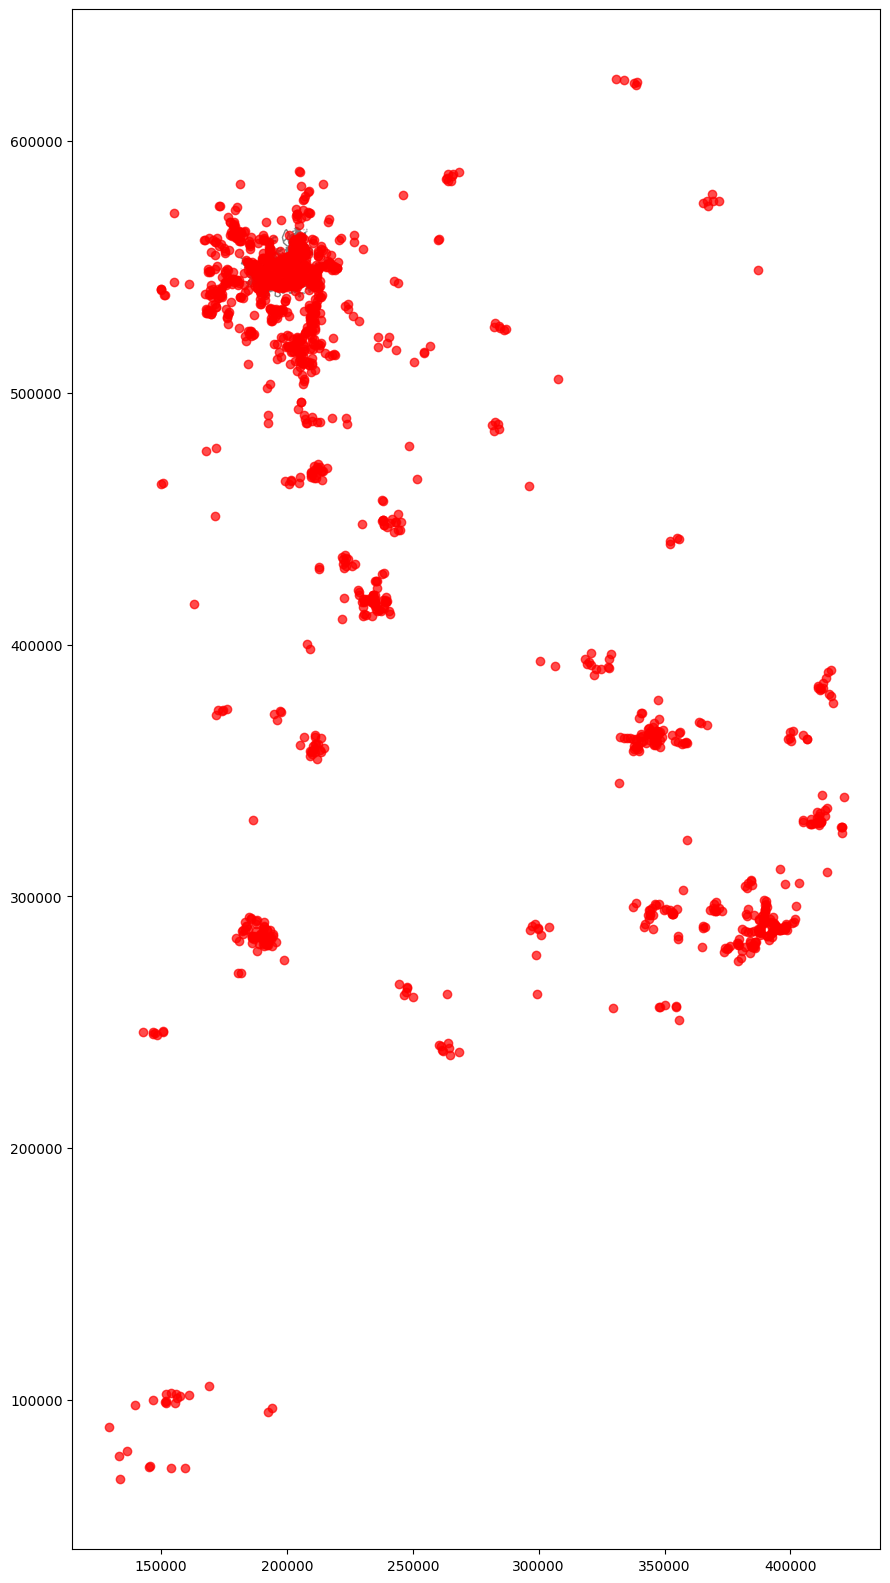

In [ ]:
starbucks = starbucks.to_crs(epsg5186)
ax = df2.convex_hull.plot(figsize = (20, 20), color='white', edgecolor='gray')
starbucks.convex_hull.plot(ax = ax, color = 'red', alpha = 0.7)
plt.show()

In [ ]:
starbucks_count = pd.DataFrame()
for i in range(len(starbucks)) :
  starbucks_count[str(i)] = df2['geometry'].intersects(starbucks['geometry'].iloc[i])

df2['starbucks_count'] = starbucks_count.sum(axis = 1)
df4 = df2.drop(df2.columns[2:7], axis = 1)
df4 = df4.iloc[:, 1:]
df4 = df4.astype({'PNU' : 'object'})

<ipython-input-51-7392f0c7b87e>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  starbucks_count[str(i)] = df2['geometry'].intersects(starbucks['geometry'].iloc[i])
<ipython-input-51-7392f0c7b87e>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  starbucks_count[str(i)] = df2['geometry'].intersects(starbucks['geometry'].iloc[i])
<ipython-input-51-7392f0c7b87e>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

In [ ]:
df2.head(2)

,index,PNU,SGG_CD,SGG_NM,EMD_CD,EMD_NM,geometry,starbucks_count
0,0,1111010100100030100,11110,종로구,11110101,청운동,"POLYGON ((197073.176 554737.046, 197092.636 55...",0
1,1,1111010100100480000,11110,종로구,11110101,청운동,"POLYGON ((197305.633 554178.725, 197306.531 55...",0


In [ ]:
df4.head(2)

,PNU,starbucks_count
0,1111010100100030100,0
1,1111010100100480000,0


In [ ]:
starbucks_pnu=df4

In [ ]:
starbucks_pnu.head(2)

,PNU,starbucks_count
0,1111010100100030100,0
1,1111010100100480000,0


## 4. 필지기준_지하철 개수


In [ ]:
subway = gpd.read_file('수도권 지하철 공간데이터/2019/TB_O_SB_STATN_2019.shp', encoding = 'cp949')

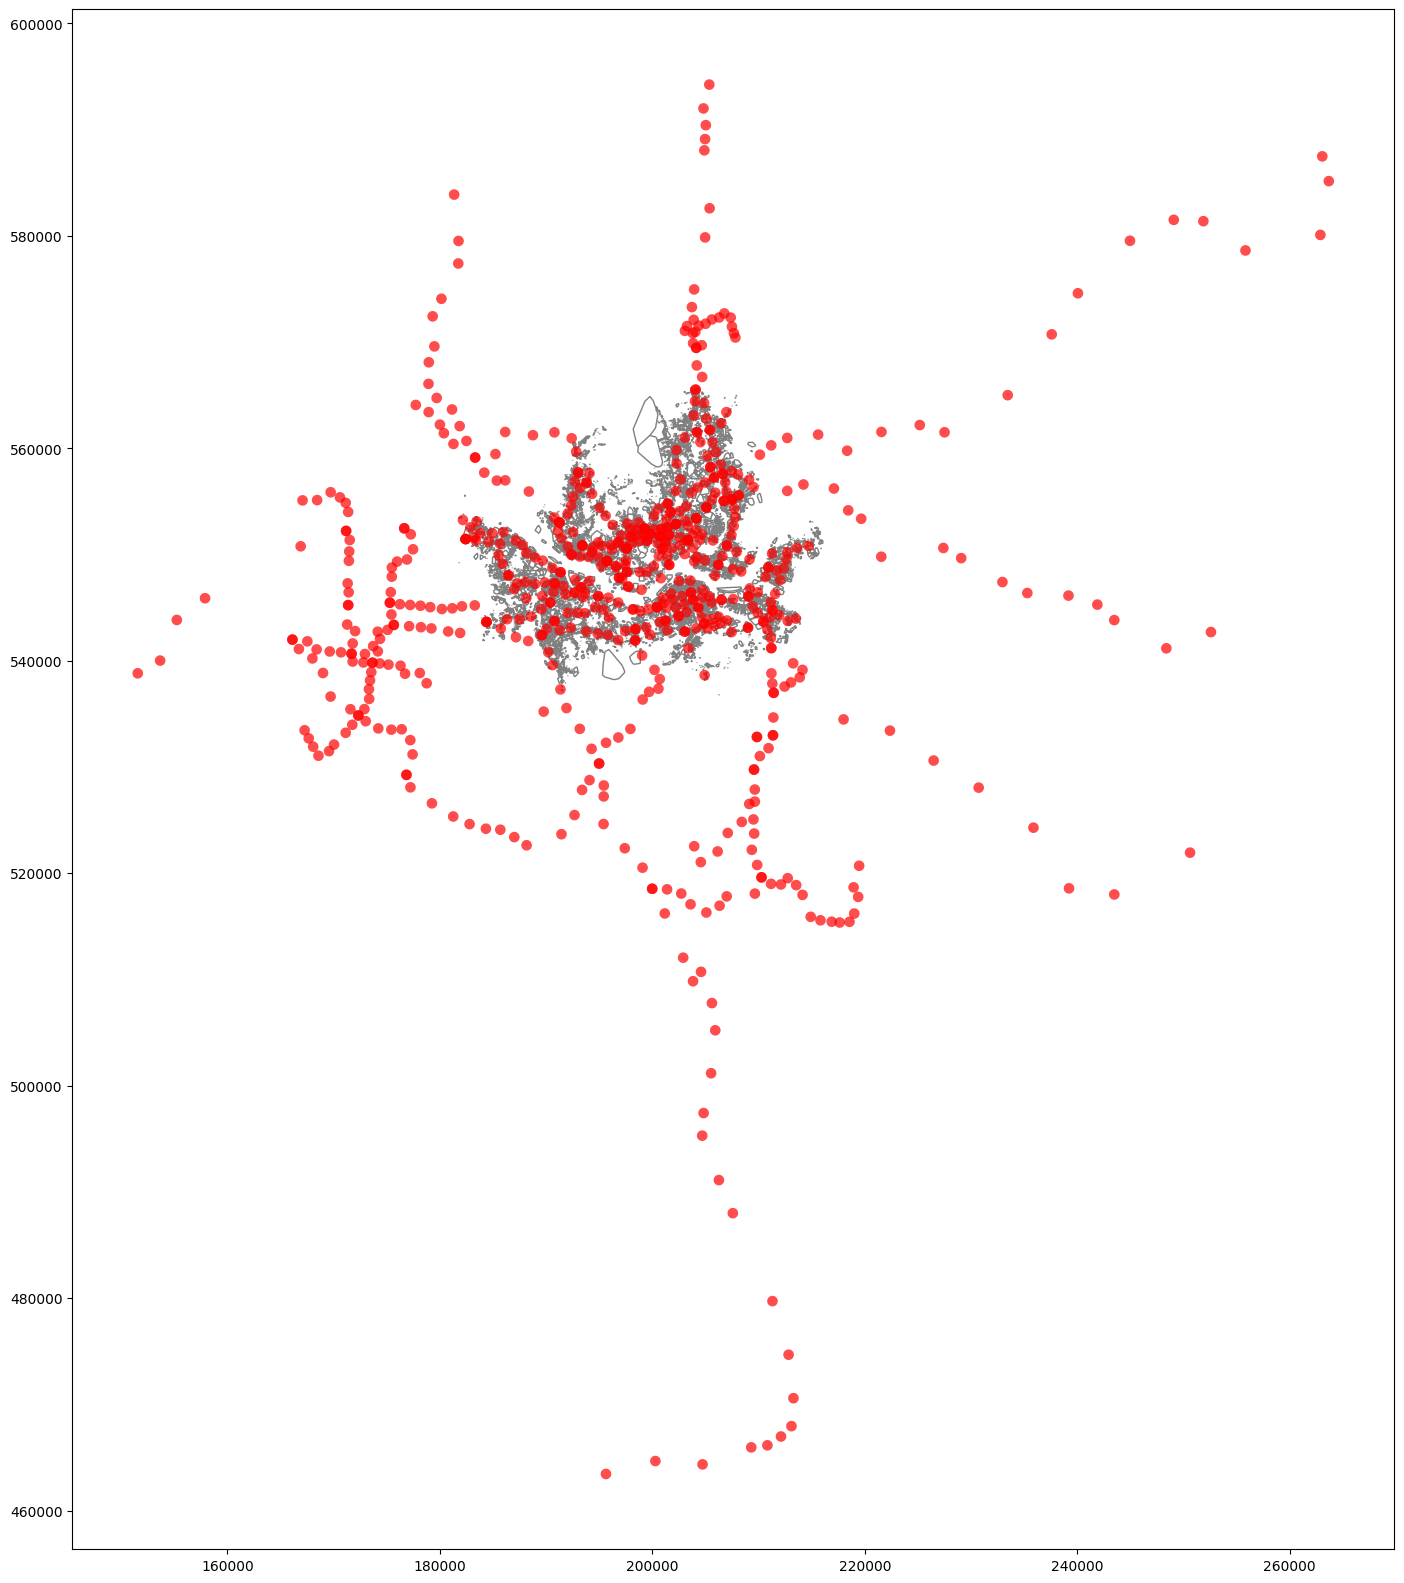

In [ ]:
#지하철 주변까지 고려하기 위하기 버퍼 500m 설정
subway['buffer'] = subway.convex_hull.buffer(500)

ax = df2.convex_hull.plot(figsize = (20, 20), color='white', edgecolor='gray')
subway['buffer'].convex_hull.plot(ax = ax, color = 'red', alpha = 0.7)
plt.show()

In [ ]:
subway_count = pd.DataFrame()
for i in range(len(subway)) :
  subway_count[str(i)] = df2['geometry'].intersects(subway['buffer'].iloc[i])

df2['subway_count'] = subway_count.sum(axis = 1)
df4 = df2.drop(df2.columns[2:7], axis = 1)
df4 = df4.iloc[:, 1:]
df4 = df4.astype({'PNU' : 'object'})

<ipython-input-58-387d64a96fb1>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subway_count[str(i)] = df2['geometry'].intersects(subway['buffer'].iloc[i])
<ipython-input-58-387d64a96fb1>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subway_count[str(i)] = df2['geometry'].intersects(subway['buffer'].iloc[i])
<ipython-input-58-387d64a96fb1>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

In [ ]:
df4.head(2)

,PNU,starbucks_count,subway_count
0,1111010100100030100,0,0
1,1111010100100480000,0,0


In [ ]:
starbucks_subway_pnu=df4

## 5. 부동산거래량 대비 유동인구 데이터

In [ ]:
# 분기별 부동산거래량 대비 유동인구를 불러옵니다.
pop2201 = pd.read_csv("부동산거래량_대비_유동인구2201_csv.csv", sep='|') # 22년3월 집계
pop2202 = pd.read_csv("부동산거래량_대비_유동인구2202_csv.csv", sep='|') # 22년 6월 집계
pop2203 = pd.read_csv("부동산거래량_대비_유동인구2203_csv.csv", sep='|') # 22년 9월 집계
pop2204 = pd.read_csv("부동산거래량_대비_유동인구2204_csv.csv", sep='|') # 22년 12월 집계
pop2301 = pd.read_csv("부동산거래량_대비_유동인구2301_csv.csv", sep='|') # 23년 3월 집계

In [ ]:
temp1 = pop2201[pop2201['induty_cd'].str.contains('A')]
temp2 = pop2202[pop2202['induty_cd'].str.contains('A')]
temp3 = pop2203[pop2203['induty_cd'].str.contains('A')]
temp4 = pop2204[pop2204['induty_cd'].str.contains('A')]
temp5 = pop2301[pop2301['induty_cd'].str.contains('A')]

In [ ]:
temp = pd.concat([temp1, temp2,temp3, temp4, temp5])

In [ ]:
temp.drop(['legaldong_cd'], axis=1, inplace=True)

### 5-1) 원본 데이터+test 데이터 합친 raw 데이터에 결합

In [ ]:
raw_data = pd.read_csv('data_given.csv', encoding='cp949')
match = pd.read_csv('필지번호_행정동.csv', encoding='cp949')
test = pd.read_excel('submission.xlsx')

In [ ]:
raw_data['train']=1

In [ ]:
# test 데이터를 불러와 train=0으로 인덱싱하여 기존의 train data와 합쳐줍니다.
test_2301 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2302 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2301['DATA_CRTR_YM'] = 202301
test_2302['DATA_CRTR_YM'] = 202302
test_2301['train']= 0
test_2302['train']=0

<ipython-input-238-3341858925e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2301['DATA_CRTR_YM'] = 202301
<ipython-input-238-3341858925e2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2302['DATA_CRTR_YM'] = 202302


In [ ]:
test_2301 = test_2301[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD']]
test_2302 = test_2302[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD']]

In [ ]:
raw_data = pd.concat([raw_data,test_2301, test_2302])

In [ ]:
temp.rename(columns={'pnu':'LT_UNQ_NO' ,'induty_cd':'INDUSTRY_CD', 'fpop_scor': '부동산거래대비유동인구'}, inplace=True)

In [ ]:
temp.reset_index(inplace=True)

In [ ]:
# train과 test를 합친 raw data와 부동산거래량 대비 유동인구 데이터를 기간에 맞춰 merge합니다.
conditions = [
    (raw_data['DATA_CRTR_YM'] <= 202203), # 조건1
    ((raw_data['DATA_CRTR_YM'] >= 202204) & (raw_data['DATA_CRTR_YM'] <= 202206)), # 조건2
    ((raw_data['DATA_CRTR_YM'] >= 202207) & (raw_data['DATA_CRTR_YM'] <= 202209)),
    ((raw_data['DATA_CRTR_YM'] >= 202210) & (raw_data['DATA_CRTR_YM'] <= 202212)),
    ((raw_data['DATA_CRTR_YM'] >= 202301) & (raw_data['DATA_CRTR_YM'] <= 202303)),
]

choices = [
    temp[temp['data_strd_ym'] == 202203],  # 조건 1에 대한 선택
    temp[temp['data_strd_ym'] == 202206],  # 조건 2에 대한 선택
    temp[temp['data_strd_ym'] == 202209],
    temp[temp['data_strd_ym'] == 202212],
    temp[temp['data_strd_ym'] == 202303],
]

pop_df = pd.DataFrame()

for i in range(len(conditions)):
    condition = conditions[i]
    selected_rows_A = raw_data[condition]
    selected_rows_B = choices[i]  # 조건에 따른 선택
    pop_df_part = pd.merge(selected_rows_A, selected_rows_B, on=['LT_UNQ_NO', 'INDUSTRY_CD'], how='left')
    pop_df = pd.concat([pop_df, pop_df_part], ignore_index=True)

In [ ]:
pop_df # 데이터 손실이 없음을 확인합니다.

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,index,data_strd_ym,부동산거래대비유동인구
0,202201,1111010100100030100,11110101,A03,4.0,1.0,1.0,202203.0,19.76
1,202201,1111010100100480000,11110101,A01,2.0,1.0,4.0,202203.0,39.13
2,202201,1111010100100590001,11110101,A11,3.0,1.0,8.0,202203.0,27.26
3,202201,1111010100100590005,11110101,A03,2.0,1.0,10.0,202203.0,21.03
4,202201,1111010100100690000,11110101,A01,2.0,1.0,13.0,202203.0,23.93
...,...,...,...,...,...,...,...,...,...
1176035,202302,1130510100100830004,11305101,A03,NaN,NaN,61516.0,202303.0,52.98
1176036,202302,1135010300107450000,11350103,A13,NaN,NaN,75809.0,202303.0,36.41
1176037,202302,1150010300103400017,11500103,A06,NaN,NaN,119214.0,202303.0,45.98
1176038,202302,1144012700116070000,11440127,A03,NaN,NaN,108200.0,202303.0,56.97


In [ ]:
pop_df.drop(['index','data_strd_ym'], axis=1, inplace=True)

### 5-2) 필지번호 매칭 안되는 것들 평균 넣어주기

In [ ]:
# 'LT_UNQ_NO' 열에서 앞 10자리를 추출합니다.
pop_df['LT_UNQ_NO_prefix'] = pop_df['LT_UNQ_NO'].astype(str).str[:10]
temp['LT_UNQ_NO_prefix'] = temp['LT_UNQ_NO'].astype(str).str[:10]

In [ ]:
# 값 대체를 위한 groupby mean 계산해서 데이터프레임 생성합니다.
sub_df = temp.groupby(['LT_UNQ_NO_prefix', 'data_strd_ym'])['부동산거래대비유동인구'].mean().reset_index()
sub_df

,LT_UNQ_NO_prefix,data_strd_ym,부동산거래대비유동인구
0,1111010100,202203,30.332941
1,1111010100,202206,29.845294
2,1111010100,202209,26.383529
3,1111010100,202212,28.202778
4,1111010100,202303,30.843125
...,...,...,...
52099,5013032026,202203,4.660000
52100,5013032026,202206,4.792727
52101,5013032026,202209,6.461667
52102,5013032026,202212,7.774545


In [ ]:
# pop_df에서 필지명이 없어서 '부동산거래대비유동인구'가 결측값인 행들 추출합니다.
not_merged = pop_df[pop_df['부동산거래대비유동인구'].isna()]
len(not_merged) # 75796

75796

In [ ]:
# 부동산거래량 대비 유동인구 데이터와 raw_data의 필지명이 매칭되지 않는 경우, 필지번호 앞 10자리를 기준으로 merge합니다.
not_2201 = pd.merge(not_merged[not_merged['DATA_CRTR_YM'] <= 202203], sub_df[sub_df['data_strd_ym']==202203], on='LT_UNQ_NO_prefix', how='left')
not_2202 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202206) & (not_merged['DATA_CRTR_YM'] > 202203)], sub_df[sub_df['data_strd_ym']==202206], on='LT_UNQ_NO_prefix', how='left')
not_2203 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202209) & (not_merged['DATA_CRTR_YM'] > 202206)], sub_df[sub_df['data_strd_ym']==202209], on='LT_UNQ_NO_prefix', how='left')
not_2204 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202212) & (not_merged['DATA_CRTR_YM'] > 202209)], sub_df[sub_df['data_strd_ym']==202212], on='LT_UNQ_NO_prefix', how='left')
not_2301 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202303) & (not_merged['DATA_CRTR_YM'] > 202212)], sub_df[sub_df['data_strd_ym']==202303], on='LT_UNQ_NO_prefix', how='left')

In [ ]:
# 분기별 데이터 하나로 합치기
notin_pop = pd.concat([not_2201, not_2202, not_2203, not_2204, not_2301])
notin_pop # 75796

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,부동산거래대비유동인구_x,LT_UNQ_NO_prefix,data_strd_ym,부동산거래대비유동인구_y
0,202201,1111010200100570000,11110102,A05,4.0,1.0,NaN,1111010200,202203.0,35.098571
1,202201,1111010400100530000,11110104,A05,5.0,1.0,NaN,1111010400,202203.0,27.218571
2,202201,1111010600100350042,11110106,A01,2.0,1.0,NaN,1111010600,202203.0,41.603529
3,202201,1111010600100370000,11110106,A02,4.0,1.0,NaN,1111010600,202203.0,41.603529
4,202201,1111010600100490001,11110106,A02,2.0,1.0,NaN,1111010600,202203.0,41.603529
...,...,...,...,...,...,...,...,...,...,...
1321,202302,1117013000101320006,11170130,A03,NaN,NaN,NaN,1117013000,202303.0,34.009218
1322,202302,1156012900100610004,11560129,A04,NaN,NaN,NaN,1156012900,202303.0,37.916607
1323,202302,1144012400102410098,11440124,A04,NaN,NaN,NaN,1144012400,202303.0,44.533655
1324,202302,1130510300105680024,11305103,A02,NaN,NaN,NaN,1130510300,202303.0,49.861538


In [ ]:
notin_pop.drop(columns='부동산거래대비유동인구_x', axis=1, inplace=True)
notin_pop.rename(columns={'부동산거래대비유동인구_y':'부동산거래대비유동인구'}, inplace=True)

### 5-3) 이 안에서 또 결측값 있어서 시군구 기준으로 평균낸 값 넣기

In [ ]:
notin_pop[notin_pop['data_strd_ym'].isna()] # 51개

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,LT_UNQ_NO_prefix,data_strd_ym,부동산거래대비유동인구
909,202201,1117010300100040000,11170103,A01,5.0,1.0,1117010300,NaN,NaN
910,202201,1117010300100190001,11170103,A01,5.0,1.0,1117010300,NaN,NaN
4332,202201,1150011100106760000,11500111,A03,3.0,1.0,1150011100,NaN,NaN
4333,202201,1150011100106760000,11500111,A01,3.0,1.0,1150011100,NaN,NaN
4916,202201,1156013100100320001,11560131,A01,2.0,1.0,1156013100,NaN,NaN
7581,202202,1117010300100190001,11170103,A01,5.0,1.0,1117010300,NaN,NaN
10510,202202,1150011100106760000,11500111,A03,3.0,1.0,1150011100,NaN,NaN
10511,202202,1150011100106760000,11500111,A01,3.0,1.0,1150011100,NaN,NaN
11003,202202,1156013100100320001,11560131,A01,1.0,1.0,1156013100,NaN,NaN
13202,202203,1117010300100040000,11170103,A01,5.0,1.0,1117010300,NaN,NaN


In [ ]:
notin_pop[notin_pop['data_strd_ym'].isna()]['LT_UNQ_NO_prefix'].unique()

array(['1117010300', '1150011100', '1156013100'], dtype=object)

In [ ]:
# 같은 동인게 없어서, 필지번호의 앞 5자리인 시군구까지 같은 것들의 평균으로 대체
notin_pop['LT_UNQ_NO_prefix2'] = notin_pop['LT_UNQ_NO'].astype(str).str[:5]
temp['LT_UNQ_NO_prefix2']= temp['LT_UNQ_NO'].astype(str).str[:5]

In [ ]:
# 값 대체를 위한 groupby mean 계산해서 데이터프레임 생성
sub_df2 = temp.groupby(['LT_UNQ_NO_prefix2', 'data_strd_ym'])['부동산거래대비유동인구'].mean().reset_index()
sub_df2

,LT_UNQ_NO_prefix2,data_strd_ym,부동산거래대비유동인구
0,11110,202203,39.469810
1,11110,202206,42.496982
2,11110,202209,45.864392
3,11110,202212,47.285565
4,11110,202303,48.186468
...,...,...,...
1200,50130,202203,30.245530
1201,50130,202206,29.048950
1202,50130,202209,29.519856
1203,50130,202212,30.693670


In [ ]:
# pop_df에서 필지명이 없어서 '부동산거래대비유동인구'가 결측값인 행들 추출
notin_pop2 = notin_pop[notin_pop['부동산거래대비유동인구'].isna()]
len(notin_pop2) # 75796

51

In [ ]:
not_2201 = pd.merge(notin_pop2[notin_pop2['DATA_CRTR_YM'] <= 202203], sub_df2[sub_df2['data_strd_ym']==202203], on='LT_UNQ_NO_prefix2', how='left')
not_2202 = pd.merge(notin_pop2[(notin_pop2['DATA_CRTR_YM'] <= 202206) & (notin_pop2['DATA_CRTR_YM'] > 202203)], sub_df2[sub_df2['data_strd_ym']==202206], on='LT_UNQ_NO_prefix2', how='left')
not_2203 = pd.merge(notin_pop2[(notin_pop2['DATA_CRTR_YM'] <= 202209) & (notin_pop2['DATA_CRTR_YM'] > 202206)], sub_df2[sub_df2['data_strd_ym']==202209], on='LT_UNQ_NO_prefix2', how='left')
not_2204 = pd.merge(notin_pop2[(notin_pop2['DATA_CRTR_YM'] <= 202212) & (notin_pop2['DATA_CRTR_YM'] > 202209)], sub_df2[sub_df2['data_strd_ym']==202212], on='LT_UNQ_NO_prefix2', how='left')
not_2301 = pd.merge(notin_pop2[(notin_pop2['DATA_CRTR_YM'] <= 202303) & (notin_pop2['DATA_CRTR_YM'] > 202212)], sub_df2[sub_df2['data_strd_ym']==202303], on='LT_UNQ_NO_prefix2', how='left')

In [ ]:
# 분기별 데이터 하나로 합치기
fill_pop = pd.concat([not_2201, not_2202, not_2203, not_2204, not_2301]).reset_index()
fill_pop.info() # 51개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              51 non-null     int64  
 1   DATA_CRTR_YM       51 non-null     int64  
 2   LT_UNQ_NO          51 non-null     int64  
 3   STDG_EMD_CD        51 non-null     int64  
 4   INDUSTRY_CD        51 non-null     object 
 5   SLS_GRD            51 non-null     float64
 6   train              51 non-null     float64
 7   LT_UNQ_NO_prefix   51 non-null     object 
 8   data_strd_ym_x     0 non-null      float64
 9   부동산거래대비유동인구_x      0 non-null      float64
 10  LT_UNQ_NO_prefix2  51 non-null     object 
 11  data_strd_ym_y     51 non-null     int64  
 12  부동산거래대비유동인구_y      51 non-null     float64
dtypes: float64(5), int64(5), object(3)
memory usage: 5.3+ KB


In [ ]:
fill_pop.drop(columns=['index','부동산거래대비유동인구_x','data_strd_ym_x'], axis=1, inplace=True)
fill_pop.rename(columns={'부동산거래대비유동인구_y':'부동산거래대비유동인구','data_strd_ym_y':'data_strd_ym'}, inplace=True)

In [ ]:
null_index = notin_pop['부동산거래대비유동인구'].isna()
notin_pop.loc[null_index, '부동산거래대비유동인구'] = fill_pop['부동산거래대비유동인구'].values

In [ ]:
# 결측값 없음 확인
notin_pop.isnull().sum()

DATA_CRTR_YM            0
LT_UNQ_NO               0
STDG_EMD_CD             0
INDUSTRY_CD             0
SLS_GRD              1326
train                1326
LT_UNQ_NO_prefix        0
data_strd_ym           51
부동산거래대비유동인구             0
LT_UNQ_NO_prefix2       0
dtype: int64

### 5-4) 최종적으로 raw_data 와 부동산거래대비 유동인구 합치기

In [ ]:
null_index2 = pop_df['부동산거래대비유동인구'].isna()
pop_df.loc[null_index2, '부동산거래대비유동인구'] = notin_pop['부동산거래대비유동인구'].values

In [ ]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176040 entries, 0 to 1176039
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   DATA_CRTR_YM      1176040 non-null  int64  
 1   LT_UNQ_NO         1176040 non-null  int64  
 2   STDG_EMD_CD       1176040 non-null  int64  
 3   INDUSTRY_CD       1176040 non-null  object 
 4   SLS_GRD           1156040 non-null  float64
 5   train             1156040 non-null  float64
 6   부동산거래대비유동인구       1176040 non-null  float64
 7   LT_UNQ_NO_prefix  1176040 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 71.8+ MB


## 6. 공실률 대비 매매가 임대료 데이터 준비하고, pop_df에 이어서 붙이기

In [ ]:
# 분기별 공실률 대비 매매가 임대료
cost2201 = pd.read_csv("공실률대비_매매가_임대료2201_csv.csv", sep='|') # 22년3월 집계
cost2202 = pd.read_csv("공실률대비_매매가_임대료2202_csv.csv", sep='|') # 22년 6월 집계
cost2203 = pd.read_csv("공실률대비_매매가_임대료2203_csv.csv", sep='|') # 22년 9월 집계
cost2204 = pd.read_csv("공실률대비_매매가_임대료2204_csv.csv", sep='|') # 22년 12월 집계
cost2301 = pd.read_csv("공실률대비_매매가_임대료2301_csv.csv", sep='|') # 23년 3월 집계

In [ ]:
temp1 = cost2201[cost2201['induty_cd'].str.contains('A')]
temp2 = cost2202[cost2202['induty_cd'].str.contains('A')]
temp3 = cost2203[cost2203['induty_cd'].str.contains('A')]
temp4 = cost2204[cost2204['induty_cd'].str.contains('A')]
temp5 = cost2301[cost2301['induty_cd'].str.contains('A')]

In [ ]:
temp = pd.concat([temp1, temp2,temp3, temp4, temp5])

In [ ]:
temp.isnull().sum()

data_strd_ym      0
pnu               0
legaldong_cd      0
induty_cd         0
snp_price_scor    0
dtype: int64

### 6-1) 원본 데이터+test 데이터 합친 raw 데이터에 결합

In [ ]:
temp.drop(['legaldong_cd'], axis=1, inplace=True)

In [ ]:
temp.rename(columns={'pnu':'LT_UNQ_NO' ,'induty_cd':'INDUSTRY_CD', 'snp_price_scor': '공실률대비매매가임대료'}, inplace=True)

In [ ]:
temp.reset_index(inplace=True)
temp.drop(['index'], axis=1, inplace=True)

In [ ]:
# 일자, 필지번호, 업종코드 기준 중복된 행 제거
temp.drop_duplicates(subset=['data_strd_ym','LT_UNQ_NO','INDUSTRY_CD'], keep='first', inplace=True, ignore_index=False)

In [ ]:
conditions = [
    (pop_df['DATA_CRTR_YM'] <= 202203),
    ((pop_df['DATA_CRTR_YM'] >= 202204) & (pop_df['DATA_CRTR_YM'] <= 202206)),
    ((pop_df['DATA_CRTR_YM'] >= 202207) & (pop_df['DATA_CRTR_YM'] <= 202209)),
    ((pop_df['DATA_CRTR_YM'] >= 202210) & (pop_df['DATA_CRTR_YM'] <= 202212)),
    ((pop_df['DATA_CRTR_YM'] >= 202301) & (pop_df['DATA_CRTR_YM'] <= 202303)),
]

choices = [
    temp[temp['data_strd_ym'] == 202203],
    temp[temp['data_strd_ym'] == 202206],
    temp[temp['data_strd_ym'] == 202209],
    temp[temp['data_strd_ym'] == 202212],
    temp[temp['data_strd_ym'] == 202303],
]

price_df = pd.DataFrame()
for i in range(len(conditions)):
    condition = conditions[i]
    selected_rows_A = pop_df[condition]
    selected_rows_B = choices[i]
    price_df_part = pd.merge(selected_rows_A, selected_rows_B, on=['LT_UNQ_NO', 'INDUSTRY_CD'], how='left')
    price_df = pd.concat([price_df, price_df_part], ignore_index=True)

In [ ]:
price_df # 데이터 손실 없음

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,부동산거래대비유동인구,LT_UNQ_NO_prefix,data_strd_ym,공실률대비매매가임대료
0,202201,1111010100100030100,11110101,A03,4.0,1.0,19.76,1111010100,NaN,NaN
1,202201,1111010100100480000,11110101,A01,2.0,1.0,39.13,1111010100,202203.0,73.91
2,202201,1111010100100590001,11110101,A11,3.0,1.0,27.26,1111010100,202203.0,64.25
3,202201,1111010100100590005,11110101,A03,2.0,1.0,21.03,1111010100,202203.0,71.80
4,202201,1111010100100690000,11110101,A01,2.0,1.0,23.93,1111010100,202203.0,79.38
...,...,...,...,...,...,...,...,...,...,...
1176035,202302,1130510100100830004,11305101,A03,NaN,NaN,52.98,1130510100,202303.0,66.38
1176036,202302,1135010300107450000,11350103,A13,NaN,NaN,36.41,1135010300,NaN,NaN
1176037,202302,1150010300103400017,11500103,A06,NaN,NaN,45.98,1150010300,202303.0,70.07
1176038,202302,1144012700116070000,11440127,A03,NaN,NaN,56.97,1144012700,202303.0,78.26


In [ ]:
price_df.drop(['data_strd_ym'], axis=1, inplace=True)

### 6-2) 필지번호 매칭 안되는 것들 평균 넣어주기

In [ ]:
# 'LT_UNQ_NO' 열에서 앞 10자리를 추출
temp['LT_UNQ_NO_prefix'] = temp['LT_UNQ_NO'].astype(str).str[:10]

In [ ]:
# 값 대체를 위한 groupby mean 계산해서 데이터프레임 생성
sub_df = temp.groupby(['LT_UNQ_NO_prefix', 'data_strd_ym'])['공실률대비매매가임대료'].mean().reset_index()
sub_df

,LT_UNQ_NO_prefix,data_strd_ym,공실률대비매매가임대료
0,1111010100,202203,73.540769
1,1111010100,202206,70.803077
2,1111010100,202209,69.832308
3,1111010100,202212,67.564286
4,1111010100,202303,66.805833
...,...,...,...
44144,5013032026,202203,99.232500
44145,5013032026,202206,99.083333
44146,5013032026,202209,99.218000
44147,5013032026,202212,99.175000


In [ ]:
# price_df에서 필지명이 없어서 '공실률대비매매가임대료'가 결측값인 행들 추출
not_merged = price_df[price_df['공실률대비매매가임대료'].isna()]
len(not_merged) # 75796

240444

In [ ]:
not_2201 = pd.merge(not_merged[not_merged['DATA_CRTR_YM'] <= 202203], sub_df[sub_df['data_strd_ym']==202203], on='LT_UNQ_NO_prefix', how='left')
not_2202 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202206) & (not_merged['DATA_CRTR_YM'] > 202203)], sub_df[sub_df['data_strd_ym']==202206], on='LT_UNQ_NO_prefix', how='left')
not_2203 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202209) & (not_merged['DATA_CRTR_YM'] > 202206)], sub_df[sub_df['data_strd_ym']==202209], on='LT_UNQ_NO_prefix', how='left')
not_2204 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202212) & (not_merged['DATA_CRTR_YM'] > 202209)], sub_df[sub_df['data_strd_ym']==202212], on='LT_UNQ_NO_prefix', how='left')
not_2301 = pd.merge(not_merged[(not_merged['DATA_CRTR_YM'] <= 202303) & (not_merged['DATA_CRTR_YM'] > 202212)], sub_df[sub_df['data_strd_ym']==202303], on='LT_UNQ_NO_prefix', how='left')

In [ ]:
# 분기별 데이터 하나로 합치기
notin_price = pd.concat([not_2201, not_2202, not_2203, not_2204, not_2301])
notin_price # 240444

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,부동산거래대비유동인구,LT_UNQ_NO_prefix,공실률대비매매가임대료_x,data_strd_ym,공실률대비매매가임대료_y
0,202201,1111010100100030100,11110101,A03,4.0,1.0,19.76,1111010100,NaN,202203.0,73.540769
1,202201,1111010100100720000,11110101,A14,4.0,1.0,17.66,1111010100,NaN,202203.0,73.540769
2,202201,1111010100100750000,11110101,A01,2.0,1.0,27.27,1111010100,NaN,202203.0,73.540769
3,202201,1111010100101310000,11110101,A03,3.0,1.0,34.70,1111010100,NaN,202203.0,73.540769
4,202201,1111010200100010028,11110102,A03,4.0,1.0,23.09,1111010200,NaN,202203.0,71.255000
...,...,...,...,...,...,...,...,...,...,...,...
4239,202302,1171010700109150000,11710107,A03,NaN,NaN,40.07,1171010700,NaN,202303.0,69.175648
4240,202302,1147010100113160000,11470101,A04,NaN,NaN,18.81,1147010100,NaN,202303.0,63.217768
4241,202302,1117010700100430117,11170107,A01,NaN,NaN,35.54,1117010700,NaN,202303.0,76.873936
4242,202302,1171010900108950000,11710109,A06,NaN,NaN,48.76,1171010900,NaN,202303.0,68.660909


In [ ]:
notin_price.drop(columns='공실률대비매매가임대료_x', axis=1, inplace=True)
notin_price.rename(columns={'공실률대비매매가임대료_y':'공실률대비매매가임대료'}, inplace=True)

### 6-3) 이 안에서 또 결측값 있어서 시군구 기준으로 평균낸 값 넣기

In [ ]:
notin_price[notin_price['data_strd_ym'].isna()] # 588개

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,부동산거래대비유동인구,LT_UNQ_NO_prefix,data_strd_ym,공실률대비매매가임대료
257,202201,1111012600100010000,11110126,A04,1.0,1.0,52.600000,1111012600,NaN,NaN
258,202201,1111012600100010000,11110126,A14,1.0,1.0,48.120000,1111012600,NaN,NaN
259,202201,1111012600100010000,11110126,A01,1.0,1.0,50.880000,1111012600,NaN,NaN
260,202201,1111012600100010000,11110126,A03,1.0,1.0,47.120000,1111012600,NaN,NaN
261,202201,1111012600100240000,11110126,A08,4.0,1.0,62.320000,1111012600,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3078,202302,1111012600100540000,11110126,A04,NaN,NaN,59.630000,1111012600,NaN,NaN
3528,202302,1111012600100010000,11110126,A04,NaN,NaN,59.630000,1111012600,NaN,NaN
3895,202302,1111012600100240000,11110126,A02,NaN,NaN,55.732727,1111012600,NaN,NaN
3904,202302,1111012600100240000,11110126,A06,NaN,NaN,46.730000,1111012600,NaN,NaN


In [ ]:
notin_price[notin_price['data_strd_ym'].isna()]['LT_UNQ_NO_prefix'].unique()

array(['1111012600', '1111017900', '1114017200', '1117010300',
       '1117010600', '1141011400', '1141011500', '1150011100',
       '1150011300', '1153011200', '1156013100'], dtype=object)

In [ ]:
# 필지번호 앞 5자리 시군구 기준으로
notin_price['LT_UNQ_NO_prefix2'] = notin_price['LT_UNQ_NO'].astype(str).str[:5]
temp['LT_UNQ_NO_prefix2'] = temp['LT_UNQ_NO'].astype(str).str[:5]

In [ ]:
# 값 대체를 위한 groupby mean 계산해서 데이터프레임 생성
sub_df2 = temp.groupby(['LT_UNQ_NO_prefix2', 'data_strd_ym'])['공실률대비매매가임대료'].mean().reset_index()
sub_df2

,LT_UNQ_NO_prefix2,data_strd_ym,공실률대비매매가임대료
0,11110,202203,75.015572
1,11110,202206,73.862203
2,11110,202209,73.213352
3,11110,202212,71.828992
4,11110,202303,71.670828
...,...,...,...
1200,50130,202203,95.752109
1201,50130,202206,96.168666
1202,50130,202209,95.738147
1203,50130,202212,95.801739


In [ ]:
# price_df에서 필지명이 없어서 '공실률대비매매가임대료'가 결측값인 행들 추출
notin_price2 = notin_price[notin_price['공실률대비매매가임대료'].isna()]
len(notin_price2) # 75796

588

In [ ]:
not_2201 = pd.merge(notin_price2[notin_price2['DATA_CRTR_YM'] <= 202203], sub_df2[sub_df2['data_strd_ym']==202203], on='LT_UNQ_NO_prefix2', how='left')
not_2202 = pd.merge(notin_price2[(notin_price2['DATA_CRTR_YM'] <= 202206) & (notin_price2['DATA_CRTR_YM'] > 202203)], sub_df2[sub_df2['data_strd_ym']==202206], on='LT_UNQ_NO_prefix2', how='left')
not_2203 = pd.merge(notin_price2[(notin_price2['DATA_CRTR_YM'] <= 202209) & (notin_price2['DATA_CRTR_YM'] > 202206)], sub_df2[sub_df2['data_strd_ym']==202209], on='LT_UNQ_NO_prefix2', how='left')
not_2204 = pd.merge(notin_price2[(notin_price2['DATA_CRTR_YM'] <= 202212) & (notin_price2['DATA_CRTR_YM'] > 202209)], sub_df2[sub_df2['data_strd_ym']==202212], on='LT_UNQ_NO_prefix2', how='left')
not_2301 = pd.merge(notin_price2[(notin_price2['DATA_CRTR_YM'] <= 202303) & (notin_price2['DATA_CRTR_YM'] > 202212)], sub_df2[sub_df2['data_strd_ym']==202303], on='LT_UNQ_NO_prefix2', how='left')

In [ ]:
# 분기별 데이터 하나로 합치기
fill_price = pd.concat([not_2201, not_2202, not_2203, not_2204, not_2301]).reset_index()
fill_price.info() # 588개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              588 non-null    int64  
 1   DATA_CRTR_YM       588 non-null    int64  
 2   LT_UNQ_NO          588 non-null    int64  
 3   STDG_EMD_CD        588 non-null    int64  
 4   INDUSTRY_CD        588 non-null    object 
 5   SLS_GRD            572 non-null    float64
 6   train              572 non-null    float64
 7   부동산거래대비유동인구        588 non-null    float64
 8   LT_UNQ_NO_prefix   588 non-null    object 
 9   data_strd_ym_x     0 non-null      float64
 10  공실률대비매매가임대료_x      0 non-null      float64
 11  LT_UNQ_NO_prefix2  588 non-null    object 
 12  data_strd_ym_y     588 non-null    int64  
 13  공실률대비매매가임대료_y      588 non-null    float64
dtypes: float64(6), int64(5), object(3)
memory usage: 64.4+ KB


In [ ]:
fill_price.drop(columns=['index','공실률대비매매가임대료_x','data_strd_ym_x'], axis=1, inplace=True)
fill_price.rename(columns={'공실률대비매매가임대료_y':'공실률대비매매가임대료','data_strd_ym_y':'data_strd_ym'}, inplace=True)

In [ ]:
null_index = notin_price['공실률대비매매가임대료'].isna()
notin_price.loc[null_index, '공실률대비매매가임대료'] = fill_price['공실률대비매매가임대료'].values

### 6-4) 최종적으로 합치기

In [ ]:
null_index2 = price_df['공실률대비매매가임대료'].isna()
price_df.loc[null_index2, '공실률대비매매가임대료'] = notin_price['공실률대비매매가임대료'].values

In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176040 entries, 0 to 1176039
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   DATA_CRTR_YM      1176040 non-null  int64  
 1   LT_UNQ_NO         1176040 non-null  int64  
 2   STDG_EMD_CD       1176040 non-null  int64  
 3   INDUSTRY_CD       1176040 non-null  object 
 4   SLS_GRD           1156040 non-null  float64
 5   train             1156040 non-null  float64
 6   부동산거래대비유동인구       1176040 non-null  float64
 7   LT_UNQ_NO_prefix  1176040 non-null  object 
 8   공실률대비매매가임대료       1176040 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 80.8+ MB


## 7. 젠트리피케이션 위험지수 이어서 합치기

In [ ]:
# 매달 젠트리피케이션 위험지수
risk2201 = pd.read_csv("젠트리피케이션_위험지수2201_csv.csv", sep='|')
risk2202 = pd.read_csv("젠트리피케이션_위험지수2202_csv.csv", sep='|')
risk2203 = pd.read_csv("젠트리피케이션_위험지수2203_csv.csv", sep='|')
risk2204 = pd.read_csv("젠트리피케이션_위험지수2204_csv.csv", sep='|')
risk2205 = pd.read_csv("젠트리피케이션_위험지수2205_csv.csv", sep='|')
risk2206 = pd.read_csv("젠트리피케이션_위험지수2206_csv.csv", sep='|')
risk2207 = pd.read_csv("젠트리피케이션_위험지수2207_csv.csv", sep='|')
risk2208 = pd.read_csv("젠트리피케이션_위험지수2208_csv.csv", sep='|')
risk2209 = pd.read_csv("젠트리피케이션_위험지수2209_csv.csv", sep='|')
risk2210 = pd.read_csv("젠트리피케이션_위험지수2210_csv.csv", sep='|')
risk2211 = pd.read_csv("젠트리피케이션_위험지수2211_csv.csv", sep='|')
risk2212 = pd.read_csv("젠트리피케이션_위험지수2212_csv.csv", sep='|')
risk2301 = pd.read_csv("젠트리피케이션_위험지수2301_csv.csv", sep='|')
risk2302 = pd.read_csv("젠트리피케이션_위험지수2302_csv.csv", sep='|')

In [ ]:
temp = pd.concat([risk2201,risk2202,risk2203,risk2204,risk2205,risk2206,risk2207,risk2208,risk2209,risk2210,risk2211,risk2212,risk2301,risk2302])

In [ ]:
temp.isnull().sum()

data_strd_ym    0
pnu             0
legaldong_cd    0
induty_cd       0
gtfc_scor       0
dtype: int64

### 7-1) 원본 데이터+test 데이터 합친 raw 데이터에 결합

In [ ]:
temp.drop(['legaldong_cd'], axis=1, inplace=True)

In [ ]:
temp.rename(columns={'data_strd_ym':'DATA_CRTR_YM','pnu':'LT_UNQ_NO' ,'induty_cd':'INDUSTRY_CD', 'gtfc_scor': '젠트리피케이션'}, inplace=True)

In [ ]:
temp.reset_index(inplace=True)
temp.drop(['index'], axis=1, inplace=True)

In [ ]:
temp.drop_duplicates(subset=['DATA_CRTR_YM','LT_UNQ_NO','INDUSTRY_CD'], keep='first', inplace=True, ignore_index=False)
len(temp) # 똑같이 12285597

12285597

In [ ]:
risk_df = pd.merge(price_df, temp, on=['DATA_CRTR_YM','LT_UNQ_NO', 'INDUSTRY_CD'], how='left')

### 7-2) 필지번호 매칭 안되는 것들 평균 넣어주기

In [ ]:
# 'LT_UNQ_NO' 열에서 앞 10자리를 추출
temp['LT_UNQ_NO_prefix'] = temp['LT_UNQ_NO'].astype(str).str[:10]

In [ ]:
# 값 대체를 위한 groupby mean 계산해서 데이터프레임 생성
sub_df = temp.groupby(['LT_UNQ_NO_prefix', 'DATA_CRTR_YM'])['젠트리피케이션'].mean().reset_index()

In [ ]:
# risk_df에서 필지명이 없어서 '젠트리피케이션'가 결측값인 행들 추출
not_merged = risk_df[risk_df['젠트리피케이션'].isna()]
len(not_merged) # 255295

255295

In [ ]:
notin_risk = pd.merge(not_merged, sub_df, on=['DATA_CRTR_YM','LT_UNQ_NO_prefix'], how='left')

In [ ]:
notin_risk.drop(columns='젠트리피케이션_x', axis=1, inplace=True)
notin_risk.rename(columns={'젠트리피케이션_y':'젠트리피케이션'}, inplace=True)

### 7-3) 이 안에서 또 결측값 있어서 시군구 기준으로 평균낸 값 넣기

In [ ]:
notin_risk[notin_risk['젠트리피케이션'].isna()] # 295개

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,부동산거래대비유동인구,LT_UNQ_NO_prefix,공실률대비매매가임대료,젠트리피케이션
230,202201,1111012600100010000,11110126,A04,1.0,1.0,52.600000,1111012600,75.015572,NaN
231,202201,1111012600100010000,11110126,A14,1.0,1.0,48.120000,1111012600,75.015572,NaN
232,202201,1111012600100010000,11110126,A01,1.0,1.0,50.880000,1111012600,75.015572,NaN
233,202201,1111012600100010000,11110126,A03,1.0,1.0,47.120000,1111012600,75.015572,NaN
234,202201,1111012600100240000,11110126,A08,4.0,1.0,62.320000,1111012600,75.015572,NaN
...,...,...,...,...,...,...,...,...,...,...
254681,202302,1111012600100540000,11110126,A04,NaN,NaN,59.630000,1111012600,71.670828,NaN
254900,202302,1111012600100010000,11110126,A04,NaN,NaN,59.630000,1111012600,71.670828,NaN
255115,202302,1111012600100240000,11110126,A02,NaN,NaN,55.732727,1111012600,71.670828,NaN
255120,202302,1111012600100240000,11110126,A06,NaN,NaN,46.730000,1111012600,71.670828,NaN


In [ ]:
notin_risk[notin_risk['젠트리피케이션'].isna()]['LT_UNQ_NO_prefix'].unique()

array(['1111012600', '1117010300', '1117010600', '1141011500',
       '1150011100', '1150011300', '1156013100'], dtype=object)

In [ ]:
notin_risk['LT_UNQ_NO_prefix2'] = notin_risk['LT_UNQ_NO'].astype(str).str[:5]
temp['LT_UNQ_NO_prefix2'] = temp['LT_UNQ_NO'].astype(str).str[:5]

In [ ]:
# 값 대체를 위한 groupby mean 계산해서 데이터프레임 생성
sub_df2 = temp.groupby(['LT_UNQ_NO_prefix2', 'DATA_CRTR_YM'])['젠트리피케이션'].mean().reset_index()
sub_df2

,LT_UNQ_NO_prefix2,DATA_CRTR_YM,젠트리피케이션
0,11110,202201,50.371309
1,11110,202202,49.902243
2,11110,202203,49.553360
3,11110,202204,49.779368
4,11110,202205,49.699615
...,...,...,...
3495,50130,202210,49.406907
3496,50130,202211,49.431767
3497,50130,202212,49.459975
3498,50130,202301,48.732068


In [ ]:
# risk_df에서 필지명이 없어서 '젠트리피케이션'가 결측값인 행들 추출
notin_risk2 = notin_risk[notin_risk['젠트리피케이션'].isna()]
len(notin_risk2) # 295

295

In [ ]:
fill_risk= pd.merge(notin_risk2,sub_df2, on=['DATA_CRTR_YM','LT_UNQ_NO_prefix2'], how='left')
fill_risk.info() # 295개

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 0 to 294
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATA_CRTR_YM       295 non-null    int64  
 1   LT_UNQ_NO          295 non-null    int64  
 2   STDG_EMD_CD        295 non-null    int64  
 3   INDUSTRY_CD        295 non-null    object 
 4   SLS_GRD            283 non-null    float64
 5   train              283 non-null    float64
 6   부동산거래대비유동인구        295 non-null    float64
 7   LT_UNQ_NO_prefix   295 non-null    object 
 8   공실률대비매매가임대료        295 non-null    float64
 9   젠트리피케이션_x          0 non-null      float64
 10  LT_UNQ_NO_prefix2  295 non-null    object 
 11  젠트리피케이션_y          295 non-null    float64
dtypes: float64(6), int64(3), object(3)
memory usage: 30.0+ KB


In [ ]:
fill_risk.drop(columns=['젠트리피케이션_x'], axis=1, inplace=True)
fill_risk.rename(columns={'젠트리피케이션_y':'젠트리피케이션'}, inplace=True)

In [ ]:
null_index2 = notin_risk['젠트리피케이션'].isna()
notin_risk.loc[null_index2, '젠트리피케이션'] = fill_risk['젠트리피케이션'].values

In [ ]:
notin_risk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255295 entries, 0 to 255294
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DATA_CRTR_YM       255295 non-null  int64  
 1   LT_UNQ_NO          255295 non-null  int64  
 2   STDG_EMD_CD        255295 non-null  int64  
 3   INDUSTRY_CD        255295 non-null  object 
 4   SLS_GRD            253044 non-null  float64
 5   train              253044 non-null  float64
 6   부동산거래대비유동인구        255295 non-null  float64
 7   LT_UNQ_NO_prefix   255295 non-null  object 
 8   공실률대비매매가임대료        255295 non-null  float64
 9   젠트리피케이션            255295 non-null  float64
 10  LT_UNQ_NO_prefix2  255295 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 23.4+ MB


### 7-4) 최종적으로 합치기

In [ ]:
risk_df[risk_df['젠트리피케이션'].isna()]

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,부동산거래대비유동인구,LT_UNQ_NO_prefix,공실률대비매매가임대료,젠트리피케이션
0,202201,1111010100100030100,11110101,A03,4.0,1.0,19.76,1111010100,73.540769,NaN
5,202201,1111010100100720000,11110101,A14,4.0,1.0,17.66,1111010100,73.540769,NaN
6,202201,1111010100100750000,11110101,A01,2.0,1.0,27.27,1111010100,73.540769,NaN
9,202201,1111010100100970000,11110101,A03,2.0,1.0,27.05,1111010100,71.640000,NaN
13,202201,1111010100101310000,11110101,A03,3.0,1.0,34.70,1111010100,73.540769,NaN
...,...,...,...,...,...,...,...,...,...,...
1175989,202302,1168010800102760001,11680108,A01,NaN,NaN,35.96,1168010800,76.636737,NaN
1175996,202302,1171010700109150000,11710107,A03,NaN,NaN,40.07,1171010700,69.175648,NaN
1176008,202302,1147010100113160000,11470101,A04,NaN,NaN,18.81,1147010100,63.217768,NaN
1176027,202302,1171010900108950000,11710109,A06,NaN,NaN,48.76,1171010900,68.660909,NaN


In [ ]:
null_index2 = risk_df['젠트리피케이션'].isna()
risk_df.loc[null_index2, '젠트리피케이션'] = notin_risk['젠트리피케이션'].values

In [ ]:
risk_df.info() # 최종적으로 결측값, 데이터 손실 없음

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   DATA_CRTR_YM      1176040 non-null  int64  
 1   LT_UNQ_NO         1176040 non-null  int64  
 2   STDG_EMD_CD       1176040 non-null  int64  
 3   INDUSTRY_CD       1176040 non-null  object 
 4   SLS_GRD           1156040 non-null  float64
 5   train             1156040 non-null  float64
 6   부동산거래대비유동인구       1176040 non-null  float64
 7   LT_UNQ_NO_prefix  1176040 non-null  object 
 8   공실률대비매매가임대료       1176040 non-null  float64
 9   젠트리피케이션           1176040 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 98.7+ MB


## 8. CPI까지 합치기

In [ ]:
CPI = pd.read_csv("생활물가지수_20230825094528.csv")
raw_data = pd.read_csv('data_given.csv', encoding='cp949')
test = pd.read_excel('submission.xlsx')

In [ ]:
test_2301 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2302 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2301['DATA_CRTR_YM'] = 202301
test_2302['DATA_CRTR_YM'] = 202302
test_2301 = test_2301[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD']]
test_2302 = test_2302[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD']]
test_2301['train']= 0
test_2302['train']=0
raw_data['train']=1
raw_data = pd.concat([raw_data,test_2301, test_2302])

<ipython-input-318-b856b11cd7a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2301['DATA_CRTR_YM'] = 202301
<ipython-input-318-b856b11cd7a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2302['DATA_CRTR_YM'] = 202302


In [ ]:
CPI.rename(columns={'시점':'DATA_CRTR_YM'}, inplace=True)
CPI.drop(['식품','식품 이외','전월세','전·월세포함 생활물가지수'], axis=1, inplace=True)
CPI['DATA_CRTR_YM'] = CPI['DATA_CRTR_YM'].str.replace(' ', '').str.replace('.', '')
CPI= CPI.astype({'DATA_CRTR_YM':'int'})

<ipython-input-319-58c0d906ab0c>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  CPI['DATA_CRTR_YM'] = CPI['DATA_CRTR_YM'].str.replace(' ', '').str.replace('.', '')


In [ ]:
risk_df['train']=risk_df['train'].fillna(0)

In [ ]:
CPI_df = pd.merge(raw_data, CPI, on='DATA_CRTR_YM', how='left')

In [ ]:
raw_data = pd.merge(CPI_df, risk_df, on=['train','DATA_CRTR_YM','LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'SLS_GRD'])
# 데이터 손실 없음

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   DATA_CRTR_YM      1176040 non-null  int64  
 1   LT_UNQ_NO         1176040 non-null  int64  
 2   STDG_EMD_CD       1176040 non-null  int64  
 3   INDUSTRY_CD       1176040 non-null  object 
 4   SLS_GRD           1156040 non-null  float64
 5   train             1176040 non-null  int64  
 6   생활물가지수            1176040 non-null  float64
 7   부동산거래대비유동인구       1176040 non-null  float64
 8   LT_UNQ_NO_prefix  1176040 non-null  object 
 9   공실률대비매매가임대료       1176040 non-null  float64
 10  젠트리피케이션           1176040 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 107.7+ MB


In [ ]:
raw_data_yoon = raw_data

### train 데이터 필지 뽑아서 match 데이터에서 행정동&필지번호 합치기

In [ ]:
raw_data = pd.read_csv('data_given.csv', encoding='cp949')
match = pd.read_csv('필지번호_행정동.csv', encoding='cp949')
test = pd.read_excel('submission.xlsx')

In [ ]:
raw_data['train']=1

In [ ]:
# test 데이터를 불러와 train=0으로 인덱싱하여 기존의 train data와 합쳐줍니다.
test_2301 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2302 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2301['DATA_CRTR_YM'] = 202301
test_2302['DATA_CRTR_YM'] = 202302
test_2301['train']= 0
test_2302['train']=0

<ipython-input-327-75bbd45ac173>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2301['DATA_CRTR_YM'] = 202301
<ipython-input-327-75bbd45ac173>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2302['DATA_CRTR_YM'] = 202302


In [ ]:
test_2301 = test_2301[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'train']]
test_2302 = test_2302[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'train']]

In [ ]:
raw_data = pd.concat([raw_data,test_2301, test_2302])

In [ ]:
# 신사동이 관악구, 강남구 둘 다에 있어서 처리해줘야함. 이외에 구는 경계에 걸친 애들
for i in range(len(match)):
    if match['ADM_NM'][i] == '신사동':
        if (match['SGG_NM'][i] == '관악구') or (match['SGG_NM'][i] == '동작구'):
            match['ADM_NM'][i] = '신사동1'
        elif (match['SGG_NM'][i] == '강남구') or (match['SGG_NM'][i] == '서초구') or (match['SGG_NM'][i] == '용산구')or (match['SGG_NM'][i] == '성동구'):
            match['ADM_NM'][i] = '신사동2'

<ipython-input-330-1122560cbe68>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match['ADM_NM'][i] = '신사동2'
<ipython-input-330-1122560cbe68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match['ADM_NM'][i] = '신사동1'


### 8-1) raw데이터에서 매칭 안되는 필지번호는 분리

In [ ]:
X = pd.DataFrame(raw_data['LT_UNQ_NO'].unique())
Y = pd.DataFrame(match['PNU'].unique())
PNU_NOTIN_data = pd.DataFrame(set(raw_data['LT_UNQ_NO'].unique())-set(match['PNU'].unique()))
PNU_IN_data = pd.DataFrame(set(raw_data['LT_UNQ_NO'].unique()) & set(match['PNU'].unique()))
PNU_NOTIN_data.rename(columns={0:'PNU'}, inplace=True)
PNU_IN_data.rename(columns={0:'PNU'}, inplace=True)

In [ ]:
raw_in_match = raw_data[raw_data['LT_UNQ_NO'].isin(PNU_IN_data['PNU'])]
raw_notin_match = raw_data[~raw_data['LT_UNQ_NO'].isin(PNU_IN_data['PNU'])]

In [ ]:
# 데이터에 있는 필지번호와 match를 merge
df = pd.merge(PNU_IN_data, match, how='left')

# 중복 필지 중 하나만 남기고 제거
df.drop_duplicates(subset='PNU', keep='first', inplace=True, ignore_index=False)

In [ ]:
# raw데이터에 행정동명 합치기
raw_in_match = pd.merge(raw_in_match, df[['PNU', 'ADM_CD', 'ADM_NM']], how='left', left_on = 'LT_UNQ_NO', right_on = 'PNU')

In [ ]:
raw_in_match = raw_in_match[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'ADM_CD', 'ADM_NM', 'INDUSTRY_CD', 'SLS_GRD', 'train']]

In [ ]:
raw_in_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172902 entries, 0 to 1172901
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1172902 non-null  int64  
 1   LT_UNQ_NO     1172902 non-null  int64  
 2   STDG_EMD_CD   1172902 non-null  int64  
 3   ADM_CD        1172902 non-null  int64  
 4   ADM_NM        1172902 non-null  object 
 5   INDUSTRY_CD   1172902 non-null  object 
 6   SLS_GRD       1152932 non-null  float64
 7   train         1172902 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 80.5+ MB


## 9. 점포수 데이터 raw_data에 붙이기

In [ ]:
# raw_in_match에서 '상일1동', '상일2동'이 데이터에서는 '상일동'. 따라서 raw_in_match의 '상일1동', '상일2동'을 '상일동'으로 바꾸어줘야함
raw_in_match['ADM_NM'][raw_in_match['ADM_NM'] == '상일1동'] = '상일동'
raw_in_match['ADM_NM'][raw_in_match['ADM_NM'] == '상일2동'] = '상일동'

<ipython-input-337-db026c552856>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_in_match['ADM_NM'][raw_in_match['ADM_NM'] == '상일2동'] = '상일동'


In [ ]:
num_store = pd.read_csv('행정동별_점포수_1.csv', encoding = 'cp949')
num_store.head()

,행정구역,생활밀접업종,22-1전체점포수,22-1프랜차이즈점포수,22-1일반점포수,22-2전체점포수,22-2프랜차이즈점포수,22-2일반점포수,22-3전체점포수,22-3프랜차이즈점포수,22-3일반점포수,22-4전체점포수,22-4프랜차이즈점포수,22-4일반점포수,23-1전체점포수,23-1프랜차이즈점포수,23-1일반점포수
0,청운효자동,전체,296,5,291,298,5,293,305,6,299,308,6,302,312,6,306
1,사직동,전체,991,121,870,996,118,878,994,120,874,"1,001",121,880,995,117,878
2,삼청동,전체,257,28,229,259,29,230,259,30,229,266,30,236,270,29,241
3,부암동,전체,132,15,117,137,15,122,135,14,121,136,14,122,133,13,120
4,평창동,전체,144,15,129,144,15,129,139,15,124,141,15,126,143,16,127


In [ ]:
# 업종 코드와 업종명을 매핑하는 딕셔너리 생성
industry_mapping = {
    'A01': '한식음식점',
    'A02': '치킨전문점',
    'A03': '전체',
    'A10': '전체',
    'A04': '제과점',
    'A05': '패스트푸드점',
    'A07': '패스트푸드점',
    'A06': '분식전문점',
    'A08': '커피-음료',
    'A09': '커피-음료',
    'A15': '커피-음료',
    'A11': '중식음식점',
    'A12': '호프-간이주점',
    'A13': '일식음식점',
    'A14': '양식음식점'
}

# '생활밀접업종' 열 추가 및 매핑
raw_in_match['생활밀접업종'] = raw_in_match['INDUSTRY_CD'].map(industry_mapping)
# print(raw_in_match)

In [ ]:
# 분기별로 merge
raw_22_1 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] <= 202203], num_store[['행정구역', '생활밀접업종', '22-1전체점포수', '22-1프랜차이즈점포수', '22-1일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_22_2 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202206) & (raw_in_match['DATA_CRTR_YM'] > 202203)], num_store[['행정구역', '생활밀접업종', '22-2전체점포수', '22-2프랜차이즈점포수', '22-2일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_22_3 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202209) & (raw_in_match['DATA_CRTR_YM'] > 202206)], num_store[['행정구역', '생활밀접업종', '22-3전체점포수', '22-3프랜차이즈점포수', '22-3일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_22_4 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202212) & (raw_in_match['DATA_CRTR_YM'] > 202209)], num_store[['행정구역', '생활밀접업종', '22-4전체점포수', '22-4프랜차이즈점포수', '22-4일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_23_1 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202302) & (raw_in_match['DATA_CRTR_YM'] > 202212)], num_store[['행정구역', '생활밀접업종', '23-1전체점포수', '23-1프랜차이즈점포수', '23-1일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_22_1.columns)
col_lst[10] = '전체점포수'
col_lst[11] = '프랜차이즈점포수'
col_lst[12] = '일반점포수'
raw_22_1.columns = col_lst
## 22-2
col_lst = list(raw_22_2.columns)
col_lst[10] = '전체점포수'
col_lst[11] = '프랜차이즈점포수'
col_lst[12] = '일반점포수'
raw_22_2.columns = col_lst
## 22-3
col_lst = list(raw_22_3.columns)
col_lst[10] = '전체점포수'
col_lst[11] = '프랜차이즈점포수'
col_lst[12] = '일반점포수'
raw_22_3.columns = col_lst
## 22-4
col_lst = list(raw_22_4.columns)
col_lst[10] = '전체점포수'
col_lst[11] = '프랜차이즈점포수'
col_lst[12] = '일반점포수'
raw_22_4.columns = col_lst
## 23-1
col_lst = list(raw_23_1.columns)
col_lst[10] = '전체점포수'
col_lst[11] = '프랜차이즈점포수'
col_lst[12] = '일반점포수'
raw_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_in_match = pd.concat([raw_22_1, raw_22_2, raw_22_3, raw_22_4, raw_23_1])
raw_in_match.drop(columns='행정구역', axis=1, inplace=True)

In [ ]:
raw_in_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172902 entries, 0 to 19969
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1172902 non-null  int64  
 1   LT_UNQ_NO     1172902 non-null  int64  
 2   STDG_EMD_CD   1172902 non-null  int64  
 3   ADM_CD        1172902 non-null  int64  
 4   ADM_NM        1172902 non-null  object 
 5   INDUSTRY_CD   1172902 non-null  object 
 6   SLS_GRD       1152932 non-null  float64
 7   train         1172902 non-null  int64  
 8   생활밀접업종        1172902 non-null  object 
 9   전체점포수         1172902 non-null  object 
 10  프랜차이즈점포수      1172902 non-null  int64  
 11  일반점포수         1172902 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 116.3+ MB


### A03, A10 비율 곱하기

In [ ]:
# A03, A10의 비율을 계산합니다.
len(raw_data[raw_data['INDUSTRY_CD']=='A03'])/len(raw_data) # 0.2918
len(raw_data[raw_data['INDUSTRY_CD']=='A10'])/len(raw_data) #0.0044

0.0044012108431686

In [ ]:
# '전체점포수'와 '일반점포수' 열에서 쉼표(,) 제거하고 문자열을 숫자로 변환
raw_in_match['전체점포수'] = raw_in_match['전체점포수'].str.replace(',', '').astype(int)
raw_in_match['일반점포수'] = raw_in_match['일반점포수'].str.replace(',', '').astype(int)

# 비율을 적용할 조건을 설정합니다.
condition_A03 = (raw_in_match['INDUSTRY_CD'] == 'A03')
condition_A10 = (raw_in_match['INDUSTRY_CD'] == 'A10')

# 데이터프레임에 조건을 적용하여 비율을 계산합니다.
raw_in_match.loc[condition_A03, ['전체점포수', '프랜차이즈점포수', '일반점포수']] *= 0.29
raw_in_match.loc[condition_A10, ['전체점포수', '프랜차이즈점포수', '일반점포수']] *= 0.0044

In [ ]:
raw_in_match.isna().sum()

DATA_CRTR_YM        0
LT_UNQ_NO           0
STDG_EMD_CD         0
ADM_CD              0
ADM_NM              0
INDUSTRY_CD         0
SLS_GRD         19970
train               0
생활밀접업종              0
전체점포수               0
프랜차이즈점포수            0
일반점포수               0
dtype: int64

## 10. 인구수 데이터 합치기

In [ ]:
num_pop = pd.read_csv('행정동별_인구수_1.csv', encoding='cp949')
num_pop.head()

,행정구역,22-1길단위유동인구,22-1주거인구,22-1직장인구,22-2길단위유동인구,22-2주거인구,22-2직장인구,22-3길단위유동인구,22-3주거인구,22-3직장인구,22-4길단위유동인구,22-4주거인구,22-4직장인구,23-1길단위유동인구,23-1주거인구,23-1직장인구
0,청운효자동,"14,929",51,44,"16,209",51,44,"14,843",51,44,"15,269",51,44,"14,633",54,44
1,사직동,"29,283",82,412,"34,630",82,412,"33,738",82,412,"34,815",82,412,"33,445",73,412
2,삼청동,"5,905",19,42,"6,885",19,42,"6,302",19,42,"6,649",19,42,"6,696",19,42
3,부암동,"5,778",45,19,"6,011",45,19,"5,468",45,19,"5,248",45,19,"4,970",44,19
4,평창동,987,22,28,986,22,28,975,22,28,"1,019",22,28,989,21,28


In [ ]:
# 분기별로 merge
raw_22_1 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] <= 202203], num_pop[['행정구역', '22-1길단위유동인구', '22-1주거인구', '22-1직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_22_2 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202206) & (raw_in_match['DATA_CRTR_YM'] > 202203)], num_pop[['행정구역', '22-2길단위유동인구', '22-2주거인구', '22-2직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_22_3 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202209) & (raw_in_match['DATA_CRTR_YM'] > 202206)], num_pop[['행정구역', '22-3길단위유동인구', '22-3주거인구', '22-3직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_22_4 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202212) & (raw_in_match['DATA_CRTR_YM'] > 202209)], num_pop[['행정구역', '22-4길단위유동인구', '22-4주거인구', '22-4직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_23_1 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202302) & (raw_in_match['DATA_CRTR_YM'] > 202212)], num_pop[['행정구역', '23-1길단위유동인구', '23-1주거인구', '23-1직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_22_1.columns)
col_lst[13] = '길단위유동인구'
col_lst[14] = '주거인구'
col_lst[15] = '직장인구'
raw_22_1.columns = col_lst
## 22-2
col_lst = list(raw_22_2.columns)
col_lst[13] = '길단위유동인구'
col_lst[14] = '주거인구'
col_lst[15] = '직장인구'
raw_22_2.columns = col_lst
## 22-3
col_lst = list(raw_22_3.columns)
col_lst[13] = '길단위유동인구'
col_lst[14] = '주거인구'
col_lst[15] = '직장인구'
raw_22_3.columns = col_lst
## 22-4
col_lst = list(raw_22_4.columns)
col_lst[13] = '길단위유동인구'
col_lst[14] = '주거인구'
col_lst[15] = '직장인구'
raw_22_4.columns = col_lst
## 23-1
col_lst = list(raw_23_1.columns)
col_lst[13] = '길단위유동인구'
col_lst[14] = '주거인구'
col_lst[15] = '직장인구'
raw_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_in_match = pd.concat([raw_22_1, raw_22_2, raw_22_3, raw_22_4, raw_23_1])
raw_in_match.drop(columns='행정구역', axis=1, inplace=True)

In [ ]:
# '길단위유동인구'와 '직장인구' 열에서 쉼표(,) 제거하고 문자열을 숫자로 변환
raw_in_match['길단위유동인구'] = raw_in_match['길단위유동인구'].str.replace(',', '').astype(int)
raw_in_match['직장인구'] = raw_in_match['직장인구'].str.replace(',', '').astype(int)

In [ ]:
raw_in_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172902 entries, 0 to 19969
Data columns (total 15 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1172902 non-null  int64  
 1   LT_UNQ_NO     1172902 non-null  int64  
 2   STDG_EMD_CD   1172902 non-null  int64  
 3   ADM_CD        1172902 non-null  int64  
 4   ADM_NM        1172902 non-null  object 
 5   INDUSTRY_CD   1172902 non-null  object 
 6   SLS_GRD       1152932 non-null  float64
 7   train         1172902 non-null  int64  
 8   생활밀접업종        1172902 non-null  object 
 9   전체점포수         1172902 non-null  float64
 10  프랜차이즈점포수      1172902 non-null  float64
 11  일반점포수         1172902 non-null  float64
 12  길단위유동인구       1172902 non-null  int64  
 13  주거인구          1172902 non-null  int64  
 14  직장인구          1172902 non-null  int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 143.2+ MB


## 11. 개폐업수 합치기

In [ ]:
open_close = pd.read_csv('행정동별_개폐업수_1.csv', encoding='cp949')
open_close.head()

,행정구역,생활밀접업종,22-1개업수,22-1폐업수,22-1개업률,22-1폐업률,22-2개업수,22-2폐업수,22-2개업률,22-2폐업률,...,22-3개업률,22-3폐업률,22-4개업수,22-4폐업수,22-4개업률,22-4폐업률,23-1개업수,23-1폐업수,23-1개업률,23-1폐업률
0,청운효자동,제과점,3,0,13.0,0.0,0,0,0.0,0.0,...,0.0,9.5,0,2,0.0,10.5,1,0,5.0,0.0
1,사직동,제과점,1,0,3.1,0.0,0,0,0.0,0.0,...,3.1,3.1,0,0,0.0,0.0,0,0,0.0,0.0
2,삼청동,제과점,0,0,0.0,0.0,0,1,0.0,7.1,...,7.7,15.4,2,0,13.3,0.0,0,0,0.0,0.0
3,부암동,제과점,1,0,14.3,0.0,0,0,0.0,0.0,...,12.5,0.0,0,0,0.0,0.0,0,1,0.0,14.3
4,평창동,제과점,0,0,0.0,0.0,0,0,0.0,0.0,...,0.0,0.0,0,1,0.0,20.0,0,0,0.0,0.0


In [ ]:
# 분기별로 merge
raw_22_1 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] <= 202203], open_close[['행정구역', '생활밀접업종', '22-1개업수', '22-1폐업수', '22-1개업률', '22-1폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_22_2 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202206) & (raw_in_match['DATA_CRTR_YM'] > 202203)], open_close[['행정구역', '생활밀접업종', '22-2개업수', '22-2폐업수', '22-2개업률', '22-2폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_22_3 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202209) & (raw_in_match['DATA_CRTR_YM'] > 202206)], open_close[['행정구역', '생활밀접업종', '22-3개업수', '22-3폐업수', '22-3개업률', '22-3폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_22_4 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202212) & (raw_in_match['DATA_CRTR_YM'] > 202209)], open_close[['행정구역', '생활밀접업종', '22-4개업수', '22-4폐업수', '22-4개업률', '22-4폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_23_1 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202302) & (raw_in_match['DATA_CRTR_YM'] > 202212)], open_close[['행정구역', '생활밀접업종', '23-1개업수', '23-1폐업수', '23-1개업률', '23-1폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_22_1.columns)
col_lst[16] = '개업수'
col_lst[17] = '폐업수'
col_lst[18] = '개업률'
col_lst[19] = '폐업률'
raw_22_1.columns = col_lst
## 22-2
col_lst = list(raw_22_2.columns)
col_lst[16] = '개업수'
col_lst[17] = '폐업수'
col_lst[18] = '개업률'
col_lst[19] = '폐업률'
raw_22_2.columns = col_lst
## 22-3
col_lst = list(raw_22_3.columns)
col_lst[16] = '개업수'
col_lst[17] = '폐업수'
col_lst[18] = '개업률'
col_lst[19] = '폐업률'
raw_22_3.columns = col_lst
## 22-4
col_lst = list(raw_22_4.columns)
col_lst[16] = '개업수'
col_lst[17] = '폐업수'
col_lst[18] = '개업률'
col_lst[19] = '폐업률'
raw_22_4.columns = col_lst
## 23-1
col_lst = list(raw_23_1.columns)
col_lst[16] = '개업수'
col_lst[17] = '폐업수'
col_lst[18] = '개업률'
col_lst[19] = '폐업률'
raw_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_in_match = pd.concat([raw_22_1, raw_22_2, raw_22_3, raw_22_4, raw_23_1])
raw_in_match.drop(columns='행정구역', axis=1, inplace=True)

In [ ]:
# 비율을 적용할 조건을 설정합니다.
condition_A03 = (raw_in_match['INDUSTRY_CD'] == 'A03')
condition_A10 = (raw_in_match['INDUSTRY_CD'] == 'A10')

# 데이터프레임에 조건을 적용하여 비율을 계산합니다.
raw_in_match.loc[condition_A03, ['개업수', '폐업수', '개업률', '폐업률']] *= 0.29
raw_in_match.loc[condition_A10, ['개업수', '폐업수', '개업률', '폐업률']] *= 0.0044

In [ ]:
raw_in_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172902 entries, 0 to 19969
Data columns (total 19 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1172902 non-null  int64  
 1   LT_UNQ_NO     1172902 non-null  int64  
 2   STDG_EMD_CD   1172902 non-null  int64  
 3   ADM_CD        1172902 non-null  int64  
 4   ADM_NM        1172902 non-null  object 
 5   INDUSTRY_CD   1172902 non-null  object 
 6   SLS_GRD       1152932 non-null  float64
 7   train         1172902 non-null  int64  
 8   생활밀접업종        1172902 non-null  object 
 9   전체점포수         1172902 non-null  float64
 10  프랜차이즈점포수      1172902 non-null  float64
 11  일반점포수         1172902 non-null  float64
 12  길단위유동인구       1172902 non-null  int64  
 13  주거인구          1172902 non-null  int64  
 14  직장인구          1172902 non-null  int64  
 15  개업수           1172902 non-null  float64
 16  폐업수           1172902 non-null  float64
 17  개업률           1172902 non-nul

## 12. 임대료 합치기

In [ ]:
fee_rent = pd.read_csv('행정동별_임대료_희중(결측값).csv')
fee_rent.head()

,행정구역,22-1 전체,22-1 1층,22-1 1층 외,22-2 전체,22-2 1층,22-2 1층 외,22-3 전체,22-3 1층,22-3 1층 외,22-4 전체,22-4 1층,22-4 1층 외,23-1 전체,23-1 1층,23-1 1층 외
0,청운효자동,129755,181103,78407,147878,212258,83498,142725,195183,90268,155797,224849,86744,151256,225252,77260
1,사직동,145664,185390,105938,162108,217048,107167,166024,228857,103192,173553,246659,100447,150227,209365,91088
2,삼청동,175042,185890,164194,161693,180283,143103,157572,194483,120661,168139,200614,135664,190228,226225,154231
3,부암동,88340,94506,82173,74155,93432,54879,93334,118701,67967,99441,122603,76278,107082,107082,82139
4,평창동,92288,115285,69292,110528,148983,72074,111164,123164,99164,121969,132186,111752,116535,126296,116535


In [ ]:
# 분기별로 merge
raw_22_1 = pd.merge(raw_in_match[raw_in_match['DATA_CRTR_YM'] <= 202203], fee_rent[['행정구역', '22-1 전체', '22-1 1층', '22-1 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_22_2 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202206) & (raw_in_match['DATA_CRTR_YM'] > 202203)], fee_rent[['행정구역', '22-2 전체', '22-2 1층', '22-2 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_22_3 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202209) & (raw_in_match['DATA_CRTR_YM'] > 202206)], fee_rent[['행정구역', '22-3 전체', '22-3 1층', '22-3 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_22_4 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202212) & (raw_in_match['DATA_CRTR_YM'] > 202209)], fee_rent[['행정구역', '22-4 전체', '22-4 1층', '22-4 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_23_1 = pd.merge(raw_in_match[(raw_in_match['DATA_CRTR_YM'] <= 202302) & (raw_in_match['DATA_CRTR_YM'] > 202212)], fee_rent[['행정구역', '23-1 전체', '23-1 1층', '23-1 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_22_1.columns)
col_lst[20] = '전체 임대료'
col_lst[21] = '1층 임대료'
col_lst[22] = '1층 외 임대료'
raw_22_1.columns = col_lst
## 22-2
col_lst = list(raw_22_2.columns)
col_lst[20] = '전체 임대료'
col_lst[21] = '1층 임대료'
col_lst[22] = '1층 외 임대료'
raw_22_2.columns = col_lst
## 22-3
col_lst = list(raw_22_3.columns)
col_lst[20] = '전체 임대료'
col_lst[21] = '1층 임대료'
col_lst[22] = '1층 외 임대료'
raw_22_3.columns = col_lst
## 22-4
col_lst = list(raw_22_4.columns)
col_lst[20] = '전체 임대료'
col_lst[21] = '1층 임대료'
col_lst[22] = '1층 외 임대료'
raw_22_4.columns = col_lst
## 23-1
col_lst = list(raw_23_1.columns)
col_lst[20] = '전체 임대료'
col_lst[21] = '1층 임대료'
col_lst[22] = '1층 외 임대료'
raw_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_in_match = pd.concat([raw_22_1, raw_22_2, raw_22_3, raw_22_4, raw_23_1])
raw_in_match.drop(columns='행정구역', axis=1, inplace=True)

In [ ]:
raw_in_match.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1172902 entries, 0 to 19969
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1172902 non-null  int64  
 1   LT_UNQ_NO     1172902 non-null  int64  
 2   STDG_EMD_CD   1172902 non-null  int64  
 3   ADM_CD        1172902 non-null  int64  
 4   ADM_NM        1172902 non-null  object 
 5   INDUSTRY_CD   1172902 non-null  object 
 6   SLS_GRD       1152932 non-null  float64
 7   train         1172902 non-null  int64  
 8   생활밀접업종        1172902 non-null  object 
 9   전체점포수         1172902 non-null  float64
 10  프랜차이즈점포수      1172902 non-null  float64
 11  일반점포수         1172902 non-null  float64
 12  길단위유동인구       1172902 non-null  int64  
 13  주거인구          1172902 non-null  int64  
 14  직장인구          1172902 non-null  int64  
 15  개업수           1172902 non-null  float64
 16  폐업수           1172902 non-null  float64
 17  개업률           1172902 non-nul

In [ ]:
raw_in_match.isna().sum()

DATA_CRTR_YM        0
LT_UNQ_NO           0
STDG_EMD_CD         0
ADM_CD              0
ADM_NM              0
INDUSTRY_CD         0
SLS_GRD         19970
train               0
생활밀접업종              0
전체점포수               0
프랜차이즈점포수            0
일반점포수               0
길단위유동인구             0
주거인구                0
직장인구                0
개업수                 0
폐업수                 0
개업률                 0
폐업률                 0
전체 임대료              0
1층 임대료              0
1층 외 임대료            0
dtype: int64

### raw_notin_match 합치기

### 공통되는 부분 필지번호 찾기

In [ ]:
# 필지번호 10자리까지가 행정구역코드여서 필지번호를 문자열로 만든 다음 10번째 자리까지 끊기
pnu_match = match['PNU'].astype(str)
pnu_notin_match = raw_notin_match['LT_UNQ_NO'].astype(str)

def str_slicing(s):
    return s[:10]

pnu_match_slice = list(map(str_slicing, pnu_match))
pnu_notin_match_slice = list(map(str_slicing, pnu_notin_match))

In [ ]:
set(pnu_notin_match_slice) - set(pnu_match_slice) # 10번째 자리까지 slice하면 match에 있는 필지번호(10자리까지)에 모두 포함됨

set()

### raw_notin_match에 slicing한 필지번호 추가해서 matching

In [ ]:
raw_notin_match['LT_UNQ_NO_slice'] = raw_notin_match['LT_UNQ_NO'].astype(str)
raw_notin_match['LT_UNQ_NO_slice'] = list(map(str_slicing, raw_notin_match['LT_UNQ_NO_slice']))
match['PNU_slice'] = match['PNU'].astype(str)
match['PNU_slice'] = list(map(str_slicing, match['PNU_slice']))

<ipython-input-368-8f66ff352c92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_notin_match['LT_UNQ_NO_slice'] = raw_notin_match['LT_UNQ_NO'].astype(str)
<ipython-input-368-8f66ff352c92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_notin_match['LT_UNQ_NO_slice'] = list(map(str_slicing, raw_notin_match['LT_UNQ_NO_slice']))


In [ ]:
raw_notin_match1 = raw_notin_match

In [ ]:
match.drop(columns='PNU', inplace=True)
match.drop_duplicates(inplace=True)

In [ ]:
raw_notin_match = pd.merge(raw_notin_match, match[['PNU_slice', 'ADM_CD', 'ADM_NM']], left_on='LT_UNQ_NO_slice', right_on='PNU_slice', how = 'left')
raw_notin_match.drop(columns=['PNU_slice'], axis=1, inplace=True)

In [ ]:
raw_notin_match = raw_notin_match[['DATA_CRTR_YM', 'LT_UNQ_NO', 'LT_UNQ_NO_slice', 'STDG_EMD_CD', 'ADM_CD', 'ADM_NM', 'INDUSTRY_CD', 'SLS_GRD',
       'train']]

### 점포수 데이터 raw_notin에 붙이기

In [ ]:
# raw_notin_match에서 '상일1동', '상일2동'이 데이터에서는 '상일동'. 따라서 raw_notin_match의 '상일1동', '상일2동'을 '상일동'으로 바꾸어줘야함
raw_notin_match['ADM_NM'][raw_notin_match['ADM_NM'] == '상일1동'] = '상일동'
raw_notin_match['ADM_NM'][raw_notin_match['ADM_NM'] == '상일2동'] = '상일동'

<ipython-input-377-8bf8fa901e0d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_notin_match['ADM_NM'][raw_notin_match['ADM_NM'] == '상일2동'] = '상일동'


In [ ]:
# 업종 코드와 업종명을 매핑하는 딕셔너리 생성
industry_mapping = {
    'A01': '한식음식점',
    'A02': '치킨전문점',
    'A03': '전체',
    'A10': '전체',
    'A04': '제과점',
    'A05': '패스트푸드점',
    'A07': '패스트푸드점',
    'A06': '분식전문점',
    'A08': '커피-음료',
    'A09': '커피-음료',
    'A15': '커피-음료',
    'A11': '중식음식점',
    'A12': '호프-간이주점',
    'A13': '일식음식점',
    'A14': '양식음식점'
}

# '생활밀접업종' 열 추가 및 매핑
raw_notin_match['생활밀접업종'] = raw_notin_match['INDUSTRY_CD'].map(industry_mapping)
# print(raw_notin_match)

In [ ]:
# 분기별로 merge
raw_notin_22_1 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] <= 202203], num_store[['행정구역', '생활밀접업종', '22-1전체점포수', '22-1프랜차이즈점포수', '22-1일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_22_2 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202206) & (raw_notin_match['DATA_CRTR_YM'] > 202203)], num_store[['행정구역', '생활밀접업종', '22-2전체점포수', '22-2프랜차이즈점포수', '22-2일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_22_3 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202209) & (raw_notin_match['DATA_CRTR_YM'] > 202206)], num_store[['행정구역', '생활밀접업종', '22-3전체점포수', '22-3프랜차이즈점포수', '22-3일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_22_4 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202212) & (raw_notin_match['DATA_CRTR_YM'] > 202209)], num_store[['행정구역', '생활밀접업종', '22-4전체점포수', '22-4프랜차이즈점포수', '22-4일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_23_1 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202302) & (raw_notin_match['DATA_CRTR_YM'] > 202212)], num_store[['행정구역', '생활밀접업종', '23-1전체점포수', '23-1프랜차이즈점포수', '23-1일반점포수']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_notin_22_1.columns)
col_lst[11] = '전체점포수'
col_lst[12] = '프랜차이즈점포수'
col_lst[13] = '일반점포수'
raw_notin_22_1.columns = col_lst
## 22-2
col_lst = list(raw_notin_22_2.columns)
col_lst[11] = '전체점포수'
col_lst[12] = '프랜차이즈점포수'
col_lst[13] = '일반점포수'
raw_notin_22_2.columns = col_lst
## 22-3
col_lst = list(raw_notin_22_3.columns)
col_lst[11] = '전체점포수'
col_lst[12] = '프랜차이즈점포수'
col_lst[13] = '일반점포수'
raw_notin_22_3.columns = col_lst
## 22-4
col_lst = list(raw_notin_22_4.columns)
col_lst[11] = '전체점포수'
col_lst[12] = '프랜차이즈점포수'
col_lst[13] = '일반점포수'
raw_notin_22_4.columns = col_lst
## 23-1
col_lst = list(raw_notin_23_1.columns)
col_lst[11] = '전체점포수'
col_lst[12] = '프랜차이즈점포수'
col_lst[13] = '일반점포수'
raw_notin_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_notin_match = pd.concat([raw_notin_22_1, raw_notin_22_2, raw_notin_22_3, raw_notin_22_4, raw_notin_23_1])
raw_notin_match.drop(columns='행정구역', axis=1, inplace=True)

### A03, A10 비율곱

In [ ]:
# '전체점포수'와 '일반점포수' 열에서 쉼표(,) 제거하고 문자열을 숫자로 변환
raw_notin_match['전체점포수'] = raw_notin_match['전체점포수'].str.replace(',', '').astype(int)
raw_notin_match['일반점포수'] = raw_notin_match['일반점포수'].str.replace(',', '').astype(int)

# 비율을 적용할 조건을 설정합니다.
condition_A03 = (raw_notin_match['INDUSTRY_CD'] == 'A03')
condition_A10 = (raw_notin_match['INDUSTRY_CD'] == 'A10')

# 데이터프레임에 조건을 적용하여 비율을 계산합니다.
raw_notin_match.loc[condition_A03, ['전체점포수', '프랜차이즈점포수', '일반점포수']] *= 0.29
raw_notin_match.loc[condition_A10, ['전체점포수', '프랜차이즈점포수', '일반점포수']] *= 0.0044

### 인구수 데이터

In [ ]:
# 분기별로 merge
raw_notin_22_1 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] <= 202203], num_pop[['행정구역', '22-1길단위유동인구', '22-1주거인구', '22-1직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_22_2 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202206) & (raw_notin_match['DATA_CRTR_YM'] > 202203)], num_pop[['행정구역', '22-2길단위유동인구', '22-2주거인구', '22-2직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_22_3 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202209) & (raw_notin_match['DATA_CRTR_YM'] > 202206)], num_pop[['행정구역', '22-3길단위유동인구', '22-3주거인구', '22-3직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_22_4 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202212) & (raw_notin_match['DATA_CRTR_YM'] > 202209)], num_pop[['행정구역', '22-4길단위유동인구', '22-4주거인구', '22-4직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_23_1 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202302) & (raw_notin_match['DATA_CRTR_YM'] > 202212)], num_pop[['행정구역', '23-1길단위유동인구', '23-1주거인구', '23-1직장인구']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_notin_22_1.columns)
col_lst[14] = '길단위유동인구'
col_lst[15] = '주거인구'
col_lst[16] = '직장인구'
raw_notin_22_1.columns = col_lst
## 22-2
col_lst = list(raw_notin_22_2.columns)
col_lst[14] = '길단위유동인구'
col_lst[15] = '주거인구'
col_lst[16] = '직장인구'
raw_notin_22_2.columns = col_lst
## 22-3
col_lst = list(raw_notin_22_3.columns)
col_lst[14] = '길단위유동인구'
col_lst[15] = '주거인구'
col_lst[16] = '직장인구'
raw_notin_22_3.columns = col_lst
## 22-4
col_lst = list(raw_notin_22_4.columns)
col_lst[14] = '길단위유동인구'
col_lst[15] = '주거인구'
col_lst[16] = '직장인구'
raw_notin_22_4.columns = col_lst
## 23-1
col_lst = list(raw_notin_23_1.columns)
col_lst[14] = '길단위유동인구'
col_lst[15] = '주거인구'
col_lst[16] = '직장인구'
raw_notin_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_notin_match = pd.concat([raw_notin_22_1, raw_notin_22_2, raw_notin_22_3, raw_notin_22_4, raw_notin_23_1])
raw_notin_match.drop(columns='행정구역', axis=1, inplace=True)

In [ ]:
# '길단위유동인구'와 '직장인구' 열에서 쉼표(,) 제거하고 문자열을 숫자로 변환
raw_notin_match['길단위유동인구'] = raw_notin_match['길단위유동인구'].str.replace(',', '').astype(int)
raw_notin_match['직장인구'] = raw_notin_match['직장인구'].str.replace(',', '').astype(int)

### 개폐업수 데이터

In [ ]:
# 분기별로 merge
raw_notin_22_1 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] <= 202203], open_close[['행정구역', '생활밀접업종', '22-1개업수', '22-1폐업수', '22-1개업률', '22-1폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_22_2 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202206) & (raw_notin_match['DATA_CRTR_YM'] > 202203)], open_close[['행정구역', '생활밀접업종', '22-2개업수', '22-2폐업수', '22-2개업률', '22-2폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_22_3 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202209) & (raw_notin_match['DATA_CRTR_YM'] > 202206)], open_close[['행정구역', '생활밀접업종', '22-3개업수', '22-3폐업수', '22-3개업률', '22-3폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_22_4 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202212) & (raw_notin_match['DATA_CRTR_YM'] > 202209)], open_close[['행정구역', '생활밀접업종', '22-4개업수', '22-4폐업수', '22-4개업률', '22-4폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')
raw_notin_23_1 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202302) & (raw_notin_match['DATA_CRTR_YM'] > 202212)], open_close[['행정구역', '생활밀접업종', '23-1개업수', '23-1폐업수', '23-1개업률', '23-1폐업률']], left_on=['ADM_NM', '생활밀접업종'], right_on = ['행정구역', '생활밀접업종'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_notin_22_1.columns)
col_lst[17] = '개업수'
col_lst[18] = '폐업수'
col_lst[19] = '개업률'
col_lst[20] = '폐업률'
raw_notin_22_1.columns = col_lst
## 22-2
col_lst = list(raw_notin_22_2.columns)
col_lst[17] = '개업수'
col_lst[18] = '폐업수'
col_lst[19] = '개업률'
col_lst[20] = '폐업률'
raw_notin_22_2.columns = col_lst
## 22-3
col_lst = list(raw_notin_22_3.columns)
col_lst[17] = '개업수'
col_lst[18] = '폐업수'
col_lst[19] = '개업률'
col_lst[20] = '폐업률'
raw_notin_22_3.columns = col_lst
## 22-4
col_lst = list(raw_notin_22_4.columns)
col_lst[17] = '개업수'
col_lst[18] = '폐업수'
col_lst[19] = '개업률'
col_lst[20] = '폐업률'
raw_notin_22_4.columns = col_lst
## 23-1
col_lst = list(raw_notin_23_1.columns)
col_lst[17] = '개업수'
col_lst[18] = '폐업수'
col_lst[19] = '개업률'
col_lst[20] = '폐업률'
raw_notin_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_notin_match = pd.concat([raw_notin_22_1, raw_notin_22_2, raw_notin_22_3, raw_notin_22_4, raw_notin_23_1])
raw_notin_match.drop(columns='행정구역', axis=1, inplace=True)

In [ ]:
# 비율을 적용할 조건을 설정합니다.
condition_A03 = (raw_notin_match['INDUSTRY_CD'] == 'A03')
condition_A10 = (raw_notin_match['INDUSTRY_CD'] == 'A10')

# 데이터프레임에 조건을 적용하여 비율을 계산합니다.
raw_notin_match.loc[condition_A03, ['개업수', '폐업수', '개업률', '폐업률']] *= 0.29
raw_notin_match.loc[condition_A10, ['개업수', '폐업수', '개업률', '폐업률']] *= 0.0044

### 임대료 데이터

In [ ]:
# 분기별로 merge
raw_notin_22_1 = pd.merge(raw_notin_match[raw_notin_match['DATA_CRTR_YM'] <= 202203], fee_rent[['행정구역', '22-1 전체', '22-1 1층', '22-1 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_22_2 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202206) & (raw_notin_match['DATA_CRTR_YM'] > 202203)], fee_rent[['행정구역', '22-2 전체', '22-2 1층', '22-2 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_22_3 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202209) & (raw_notin_match['DATA_CRTR_YM'] > 202206)], fee_rent[['행정구역', '22-3 전체', '22-3 1층', '22-3 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_22_4 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202212) & (raw_notin_match['DATA_CRTR_YM'] > 202209)], fee_rent[['행정구역', '22-4 전체', '22-4 1층', '22-4 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')
raw_notin_23_1 = pd.merge(raw_notin_match[(raw_notin_match['DATA_CRTR_YM'] <= 202302) & (raw_notin_match['DATA_CRTR_YM'] > 202212)], fee_rent[['행정구역', '23-1 전체', '23-1 1층', '23-1 1층 외']], left_on=['ADM_NM'], right_on = ['행정구역'], how='left')

In [ ]:
# 열 이름 통일
## 22-1
col_lst = list(raw_notin_22_1.columns)
col_lst[21] = '전체 임대료'
col_lst[22] = '1층 임대료'
col_lst[23] = '1층 외 임대료'
raw_notin_22_1.columns = col_lst
## 22-2
col_lst = list(raw_notin_22_2.columns)
col_lst[21] = '전체 임대료'
col_lst[22] = '1층 임대료'
col_lst[23] = '1층 외 임대료'
raw_notin_22_2.columns = col_lst
## 22-3
col_lst = list(raw_notin_22_3.columns)
col_lst[21] = '전체 임대료'
col_lst[22] = '1층 임대료'
col_lst[23] = '1층 외 임대료'
raw_notin_22_3.columns = col_lst
## 22-4
col_lst = list(raw_notin_22_4.columns)
col_lst[21] = '전체 임대료'
col_lst[22] = '1층 임대료'
col_lst[23] = '1층 외 임대료'
raw_notin_22_4.columns = col_lst
## 23-1
col_lst = list(raw_notin_23_1.columns)
col_lst[21] = '전체 임대료'
col_lst[22] = '1층 임대료'
col_lst[23] = '1층 외 임대료'
raw_notin_23_1.columns = col_lst

In [ ]:
# 분기별 데이터 하나로 합치기
raw_notin_match = pd.concat([raw_notin_22_1, raw_notin_22_2, raw_notin_22_3, raw_notin_22_4, raw_notin_23_1])
raw_notin_match.drop(columns='행정구역', axis=1, inplace=True)

### groupby mean

In [ ]:
# 행정코드 10자리, 업종코드, 연월로 그룹화하여 평균 구하기
grouped = raw_notin_match.groupby(['LT_UNQ_NO_slice', 'INDUSTRY_CD', 'DATA_CRTR_YM'])[['전체점포수',
       '프랜차이즈점포수', '일반점포수', '길단위유동인구', '주거인구', '직장인구', '개업수', '폐업수', '개업률',
       '폐업률', '전체 임대료', '1층 임대료', '1층 외 임대료']].mean().reset_index()

In [ ]:
raw_notin_match2 = pd.merge(raw_notin_match1, grouped, on=['LT_UNQ_NO_slice', 'INDUSTRY_CD', 'DATA_CRTR_YM'])
raw_notin_match2.drop(columns='LT_UNQ_NO_slice', inplace=True)

In [ ]:
# raw_notin_match2에는 행정동코드, 행정동명, 생활밀접업종 열이 없으므로 raw_in_match에서도 drop
raw_in_match.drop(columns=['ADM_CD', 'ADM_NM', '생활밀접업종'], inplace=True)

In [ ]:
raw_data1 = pd.concat([raw_in_match, raw_notin_match2]).sort_values(by='DATA_CRTR_YM').reset_index(drop=True)
raw_data1.info() # 초기 raw_data의 length인 1176040과 일치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176040 entries, 0 to 1176039
Data columns (total 19 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  int64  
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
 6   전체점포수         1176040 non-null  float64
 7   프랜차이즈점포수      1176040 non-null  float64
 8   일반점포수         1176040 non-null  float64
 9   길단위유동인구       1176040 non-null  float64
 10  주거인구          1176040 non-null  float64
 11  직장인구          1176040 non-null  float64
 12  개업수           1176040 non-null  float64
 13  폐업수           1176040 non-null  float64
 14  개업률           1176040 non-null  float64
 15  폐업률           1176040 non-null  float64
 16  전체 임대료        1176040 non-null  float64
 17  1층 임대료        1176040 non-n

In [ ]:
raw_data1.isna().sum() # test데이터 10000개이므로 202301,202302 해서 20000개 맞음.

DATA_CRTR_YM        0
LT_UNQ_NO           0
STDG_EMD_CD         0
INDUSTRY_CD         0
SLS_GRD         20000
train               0
전체점포수               0
프랜차이즈점포수            0
일반점포수               0
길단위유동인구             0
주거인구                0
직장인구                0
개업수                 0
폐업수                 0
개업률                 0
폐업률                 0
전체 임대료              0
1층 임대료              0
1층 외 임대료            0
dtype: int64

In [ ]:
raw_data_yh = pd.merge(raw_data1, raw_data_yoon)

In [ ]:
raw_data_yh.drop(columns='LT_UNQ_NO_prefix', inplace=True)

In [ ]:
raw_data_yh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 23 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  int64  
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
 6   전체점포수         1176040 non-null  float64
 7   프랜차이즈점포수      1176040 non-null  float64
 8   일반점포수         1176040 non-null  float64
 9   길단위유동인구       1176040 non-null  float64
 10  주거인구          1176040 non-null  float64
 11  직장인구          1176040 non-null  float64
 12  개업수           1176040 non-null  float64
 13  폐업수           1176040 non-null  float64
 14  개업률           1176040 non-null  float64
 15  폐업률           1176040 non-null  float64
 16  전체 임대료        1176040 non-null  float64
 17  1층 임대료        1176040 non-n

### raw data_yh와 행정동별 노인인구수 & 대학교 포함여부 & 스타벅스/지하철 개수 merge

In [ ]:
merge_df = pd.merge(left = raw_data_yh, right = pop65, on = ['DATA_CRTR_YM', 'LT_UNQ_NO', 'INDUSTRY_CD'], how = 'left')
merge_df = pd.merge(left = merge_df, right = college_pnu, on = ['DATA_CRTR_YM', 'LT_UNQ_NO', 'INDUSTRY_CD'], how = 'left')

merge_df.columns

Index(['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD_x', 'INDUSTRY_CD',
       'SLS_GRD_x', 'train_x', '전체점포수', '프랜차이즈점포수', '일반점포수', '길단위유동인구', '주거인구',
       '직장인구', '개업수', '폐업수', '개업률', '폐업률', '전체 임대료', '1층 임대료', '1층 외 임대료',
       '생활물가지수', '부동산거래대비유동인구', '공실률대비매매가임대료', '젠트리피케이션', 'STDG_EMD_CD_y',
       'SLS_GRD_y', 'train_y', '65세이상', '65세이상_남', '65세이상_여', 'STDG_EMD_CD',
       'SLS_GRD', 'train', 'college_count'],
      dtype='object')

In [ ]:
merge_df2 = merge_df[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'SLS_GRD', 'train',
                      '전체점포수', '프랜차이즈점포수', '일반점포수', '길단위유동인구', '주거인구', '직장인구',
                      '개업수', '폐업수', '개업률', '폐업률', '전체 임대료', '1층 임대료', '1층 외 임대료',
                      '생활물가지수', '부동산거래대비유동인구', '공실률대비매매가임대료', '젠트리피케이션',
                      '65세이상', '65세이상_남', '65세이상_여', 'college_count']]
merge_df2

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,전체점포수,프랜차이즈점포수,일반점포수,길단위유동인구,...,1층 임대료,1층 외 임대료,생활물가지수,부동산거래대비유동인구,공실률대비매매가임대료,젠트리피케이션,65세이상,65세이상_남,65세이상_여,college_count
0,202201,1111010100100030100,11110101,A03,4.0,1,85.840000,1.450000,84.390000,14929.000000,...,181103.000000,78407.0,104.55,19.76,73.540769,51.190526,2144.000000,875.000000,1269.000000,0
1,202201,1156011100104460000,11560111,A01,5.0,1,295.000000,23.000000,272.000000,92745.000000,...,115405.000000,71093.0,104.55,51.69,68.320000,43.180000,3386.000000,1506.000000,1880.000000,0
2,202201,1156011100104450001,11560111,A03,3.0,1,181.830000,25.230000,156.600000,92745.000000,...,115405.000000,71093.0,104.55,50.71,65.170000,45.610000,3386.000000,1506.000000,1880.000000,0
3,202201,1156011100104390000,11560111,A04,4.0,1,14.000000,3.000000,11.000000,92745.000000,...,115405.000000,71093.0,104.55,29.72,68.100000,49.390000,3386.000000,1506.000000,1880.000000,0
4,202201,1156011100104340000,11560111,A01,5.0,1,295.000000,23.000000,272.000000,92745.000000,...,115405.000000,71093.0,104.55,51.69,68.300000,46.940000,3386.000000,1506.000000,1880.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176035,202302,1147010200104060293,11470102,A01,NaN,0,202.000000,37.000000,165.000000,31650.000000,...,185154.000000,99984.0,112.01,69.75,63.440000,48.680000,3537.000000,1632.000000,1905.000000,0
1176036,202302,1159010100100950000,11590101,A01,NaN,0,272.000000,23.000000,249.000000,33776.000000,...,158830.000000,131145.0,112.01,68.17,72.350000,51.210000,6007.000000,2582.000000,3425.000000,0
1176037,202302,1121510100102110002,11215101,A06,NaN,0,21.000000,5.000000,16.000000,81107.000000,...,98719.000000,95021.0,112.01,33.42,71.890000,33.150000,2957.000000,1310.000000,1647.000000,0
1176038,202302,1174010200101940007,11740102,A03,NaN,0,49.300000,13.050000,36.250000,9669.000000,...,270410.000000,148667.0,112.01,59.75,62.080000,45.270000,3189.000000,1552.000000,1637.000000,0


In [ ]:
#merge_df2.to_csv('데이터셋/raw_data_다경.csv', index = False, encoding = 'cp949')
raw_dak0=merge_df2
# raw_다경 = raw_희중 + 대학교여부 + 65세 이상 남/여 스타벅스/지하철
# raw_수빈 = raw_다경 + 스타벅스/지하철

In [ ]:
starbucks_subway_pnu.head(2)

,PNU,starbucks_count,subway_count
0,1111010100100030100,0,0
1,1111010100100480000,0,0


In [ ]:
starbucks_subway_pnu['LT_UNQ_NO'] = starbucks_subway_pnu['PNU']
subway_pnu=starbucks_subway_pnu.iloc[:,1:]
starbucks_subway_pnu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74199 entries, 0 to 74198
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PNU              74199 non-null  object
 1   starbucks_count  74199 non-null  int64 
 2   subway_count     74199 non-null  int64 
 3   LT_UNQ_NO        74199 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [ ]:
df_sub = pd.merge(raw_dak0, subway_pnu, on='LT_UNQ_NO', how='left')

In [ ]:
df_sub.head(2)

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,전체점포수,프랜차이즈점포수,일반점포수,길단위유동인구,...,생활물가지수,부동산거래대비유동인구,공실률대비매매가임대료,젠트리피케이션,65세이상,65세이상_남,65세이상_여,college_count,starbucks_count,subway_count
0,202201,1111010100100030100,11110101,A03,4.0,1,85.84,1.45,84.39,14929.0,...,104.55,19.76,73.540769,51.190526,2144.0,875.0,1269.0,0,0.0,0.0
1,202201,1156011100104460000,11560111,A01,5.0,1,295.00,23.00,272.00,92745.0,...,104.55,51.69,68.320000,43.180000,3386.0,1506.0,1880.0,0,0.0,2.0


In [ ]:
df_sub['subway_count'].isna().sum()

3138

지하철 개수

In [ ]:
# 'LT_UNQ_NO' 열에서 앞 8자리를 추출
starbucks_subway_pnu['STDG_EMD_CD'] = starbucks_subway_pnu['LT_UNQ_NO'].astype(str).str[:8]

In [ ]:
starbucks_subway_pnu= starbucks_subway_pnu.astype({'STDG_EMD_CD' : 'int'})
starbucks_subway_pnu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74199 entries, 0 to 74198
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PNU              74199 non-null  object
 1   starbucks_count  74199 non-null  int64 
 2   subway_count     74199 non-null  int64 
 3   LT_UNQ_NO        74199 non-null  object
 4   STDG_EMD_CD      74199 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


In [ ]:
sub_df = starbucks_subway_pnu.groupby(['STDG_EMD_CD'])['subway_count'].mean().reset_index()
sub_df.head(2)

,STDG_EMD_CD,subway_count
0,11110101,0.0
1,11110102,0.0


In [ ]:
not_merged = df_sub[df_sub['subway_count'].isna()]
len(not_merged) # 3138

3138

In [ ]:
df_sub8 = pd.merge(not_merged, sub_df, on='STDG_EMD_CD', how='left')

In [ ]:
df_sub8.head(2)

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,전체점포수,프랜차이즈점포수,일반점포수,길단위유동인구,...,부동산거래대비유동인구,공실률대비매매가임대료,젠트리피케이션,65세이상,65세이상_남,65세이상_여,college_count,starbucks_count,subway_count_x,subway_count_y
0,202201,1171010800106510014,11710108,A03,2.0,1,107.04625,23.16375,83.8825,47727.75,...,52.10,72.248746,48.796471,4009.25,1859.375,2149.875,0,NaN,NaN,0.710963
1,202201,1171010800106510015,11710108,A03,3.0,1,107.04625,23.16375,83.8825,47727.75,...,45.47,72.248746,48.796471,4009.25,1859.375,2149.875,0,NaN,NaN,0.710963


In [ ]:
df_sub8.drop(columns='subway_count_x', axis=1, inplace=True)
df_sub8.rename(columns={'subway_count_y':'subway_count'}, inplace=True)
df_sub8['subway_count'].isna().sum()

0

In [ ]:
null_index = df_sub['subway_count'].isna()
df_sub.loc[null_index, 'subway_count'] = df_sub8['subway_count'].values
df_sub['subway_count'].isna().sum()

0

In [ ]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 29 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   DATA_CRTR_YM     1176040 non-null  int64  
 1   LT_UNQ_NO        1176040 non-null  object 
 2   STDG_EMD_CD      1176040 non-null  int64  
 3   INDUSTRY_CD      1176040 non-null  object 
 4   SLS_GRD          1156040 non-null  float64
 5   train            1176040 non-null  int64  
 6   전체점포수            1176040 non-null  float64
 7   프랜차이즈점포수         1176040 non-null  float64
 8   일반점포수            1176040 non-null  float64
 9   길단위유동인구          1176040 non-null  float64
 10  주거인구             1176040 non-null  float64
 11  직장인구             1176040 non-null  float64
 12  개업수              1176040 non-null  float64
 13  폐업수              1176040 non-null  float64
 14  개업률              1176040 non-null  float64
 15  폐업률              1176040 non-null  float64
 16  전체 임대료           1

In [ ]:
starbucks_pnu['LT_UNQ_NO'] = starbucks_pnu['PNU']
starbucks_pnu=starbucks_pnu.iloc[:,1:]
starbucks_pnu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74199 entries, 0 to 74198
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   starbucks_count  74199 non-null  int64 
 1   LT_UNQ_NO        74199 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
df_LT = pd.merge(df_sub, starbucks_pnu, on='LT_UNQ_NO', how='left')

In [ ]:
df_LT.drop(columns='starbucks_count_x', axis=1, inplace=True)
df_LT.rename(columns={'starbucks_count_y':'starbucks_count'}, inplace=True)
df_LT['starbucks_count'].isna().sum()

3138

In [ ]:
df_LT.head(2)

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,전체점포수,프랜차이즈점포수,일반점포수,길단위유동인구,...,생활물가지수,부동산거래대비유동인구,공실률대비매매가임대료,젠트리피케이션,65세이상,65세이상_남,65세이상_여,college_count,subway_count,starbucks_count
0,202201,1111010100100030100,11110101,A03,4.0,1,85.84,1.45,84.39,14929.0,...,104.55,19.76,73.540769,51.190526,2144.0,875.0,1269.0,0,0.0,0.0
1,202201,1156011100104460000,11560111,A01,5.0,1,295.00,23.00,272.00,92745.0,...,104.55,51.69,68.320000,43.180000,3386.0,1506.0,1880.0,0,2.0,0.0


필지번호 매칭 안되는 것들 평균 넣어주기

In [ ]:
# 'LT_UNQ_NO' 열에서 앞 8자리를 추출
starbucks_pnu['STDG_EMD_CD'] = starbucks_pnu['LT_UNQ_NO'].astype(str).str[:8]

In [ ]:
starbucks_pnu= starbucks_pnu.astype({'STDG_EMD_CD' : 'int'})
starbucks_pnu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74199 entries, 0 to 74198
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   starbucks_count  74199 non-null  int64 
 1   LT_UNQ_NO        74199 non-null  object
 2   STDG_EMD_CD      74199 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.7+ MB


In [ ]:
sub_df1 = starbucks_pnu.groupby(['STDG_EMD_CD'])['starbucks_count'].mean().reset_index()
sub_df1.head(2)

,STDG_EMD_CD,starbucks_count
0,11110101,0.0
1,11110102,0.0


In [ ]:
not_merged = df_LT[df_LT['starbucks_count'].isna()]
len(not_merged) # 3138

3138

In [ ]:
df_LT8 = pd.merge(not_merged, sub_df1, on='STDG_EMD_CD', how='left')
df_LT8.head(2)

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,전체점포수,프랜차이즈점포수,일반점포수,길단위유동인구,...,부동산거래대비유동인구,공실률대비매매가임대료,젠트리피케이션,65세이상,65세이상_남,65세이상_여,college_count,subway_count,starbucks_count_x,starbucks_count_y
0,202201,1171010800106510014,11710108,A03,2.0,1,107.04625,23.16375,83.8825,47727.75,...,52.10,72.248746,48.796471,4009.25,1859.375,2149.875,0,0.710963,NaN,0.013289
1,202201,1171010800106510015,11710108,A03,3.0,1,107.04625,23.16375,83.8825,47727.75,...,45.47,72.248746,48.796471,4009.25,1859.375,2149.875,0,0.710963,NaN,0.013289


In [ ]:
df_LT8.drop(columns='starbucks_count_x', axis=1, inplace=True)
df_LT8.rename(columns={'starbucks_count_y':'starbucks_count'}, inplace=True)
df_LT8['starbucks_count'].isna().sum()

0

In [ ]:
null_index2 = df_LT['starbucks_count'].isna()
df_LT.loc[null_index2, 'starbucks_count'] = df_LT8['starbucks_count'].values
df_LT['starbucks_count'].isna().sum()

0

In [ ]:
df_LT.head(2)

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,전체점포수,프랜차이즈점포수,일반점포수,길단위유동인구,...,생활물가지수,부동산거래대비유동인구,공실률대비매매가임대료,젠트리피케이션,65세이상,65세이상_남,65세이상_여,college_count,subway_count,starbucks_count
0,202201,1111010100100030100,11110101,A03,4.0,1,85.84,1.45,84.39,14929.0,...,104.55,19.76,73.540769,51.190526,2144.0,875.0,1269.0,0,0.0,0.0
1,202201,1156011100104460000,11560111,A01,5.0,1,295.00,23.00,272.00,92745.0,...,104.55,51.69,68.320000,43.180000,3386.0,1506.0,1880.0,0,2.0,0.0


In [ ]:
df_LT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 29 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   DATA_CRTR_YM     1176040 non-null  int64  
 1   LT_UNQ_NO        1176040 non-null  object 
 2   STDG_EMD_CD      1176040 non-null  int64  
 3   INDUSTRY_CD      1176040 non-null  object 
 4   SLS_GRD          1156040 non-null  float64
 5   train            1176040 non-null  int64  
 6   전체점포수            1176040 non-null  float64
 7   프랜차이즈점포수         1176040 non-null  float64
 8   일반점포수            1176040 non-null  float64
 9   길단위유동인구          1176040 non-null  float64
 10  주거인구             1176040 non-null  float64
 11  직장인구             1176040 non-null  float64
 12  개업수              1176040 non-null  float64
 13  폐업수              1176040 non-null  float64
 14  개업률              1176040 non-null  float64
 15  폐업률              1176040 non-null  float64
 16  전체 임대료           1

In [ ]:
raw_subin = df_LT.rename(columns={'subway_count': '지하철개수', 'starbucks_count': '스타벅스개수', 'college_count': '대학교여부'})

In [ ]:
raw_subin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 29 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  object 
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
 6   전체점포수         1176040 non-null  float64
 7   프랜차이즈점포수      1176040 non-null  float64
 8   일반점포수         1176040 non-null  float64
 9   길단위유동인구       1176040 non-null  float64
 10  주거인구          1176040 non-null  float64
 11  직장인구          1176040 non-null  float64
 12  개업수           1176040 non-null  float64
 13  폐업수           1176040 non-null  float64
 14  개업률           1176040 non-null  float64
 15  폐업률           1176040 non-null  float64
 16  전체 임대료        1176040 non-null  float64
 17  1층 임대료        1176040 non-n

## 14. 지하철 출퇴근 인원수

In [ ]:
raw_df = pd.read_csv('필지단위 소상공인 매출등급 정보.csv', encoding = 'cp949')
test = pd.read_excel('소상공인 매출등급 예상 대상 필지.xlsx')

# train이면 1, test면 0 변수 생성
raw_df['train'] = 1
# test 데이터는 202301과 202302가 열별로 되어있어 각각 데이터프레임 만든 후 raw데이터 밑으로 붙이기
test_2301 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2302 = test[['LT_UNQ_NO', 'INDUSTRY_CD', 'STDG_EMD_CD']]
test_2301['DATA_CRTR_YM'] = 202301
test_2302['DATA_CRTR_YM'] = 202302
test_2301['train'] = 0
test_2302['train'] = 0

test_2301 = test_2301[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'train']]
test_2302 = test_2302[['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'train']]

raw_df = pd.concat([raw_df, test_2301, test_2302])
raw_df.info()

<ipython-input-97-e41cd8f25b6c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2301['DATA_CRTR_YM'] = 202301
<ipython-input-97-e41cd8f25b6c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2302['DATA_CRTR_YM'] = 202302


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  int64  
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 62.8+ MB


필지번호와 지하철역 이름 매칭


서울시 필지 shp 중에서 raw_data에 존재하는 필지만 뽑은 후, geometry 붙여놓기

In [ ]:
temp = raw_df.drop_duplicates(subset = 'LT_UNQ_NO', keep = 'first', ignore_index = True)
temp = temp[['LT_UNQ_NO']]
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74303 entries, 0 to 74302
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LT_UNQ_NO  74303 non-null  int64
dtypes: int64(1)
memory usage: 580.6 KB


In [ ]:
pnu_data = pd.merge(left = seoul_pnu, right = temp, left_on = 'PNU', right_on = 'LT_UNQ_NO', how = 'right')
pnu_data.head(2)

,PNU,SGG_CD,SGG_NM,EMD_CD,EMD_NM,geometry,LT_UNQ_NO
0,1.111010e+18,11110,종로구,11110101,청운동,"POLYGON ((197073.176 554737.046, 197092.636 55...",1111010100100030100
1,1.111010e+18,11110,종로구,11110101,청운동,"POLYGON ((197305.633 554178.725, 197306.531 55...",1111010100100480000


In [ ]:
pnu_data.drop(['PNU'], axis = 1, inplace = True)
pnu_data = pnu_data[['LT_UNQ_NO', 'SGG_CD', 'SGG_NM', 'EMD_CD', 'EMD_NM', 'geometry']]
pnu_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74303 entries, 0 to 74302
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LT_UNQ_NO  74303 non-null  int64   
 1   SGG_CD     74199 non-null  object  
 2   SGG_NM     74199 non-null  object  
 3   EMD_CD     74199 non-null  object  
 4   EMD_NM     74199 non-null  object  
 5   geometry   74199 non-null  geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 4.0+ MB


pnu_data에 역 이름 붙여놓기

In [ ]:
import re
pattern = r'\([^)]*\)'

In [ ]:
subway['STN_NM'] = subway['STN_NM'].apply(lambda x: re.sub(pattern, repl='', string = x))
subway = subway.to_crs(epsg = 5186)

In [ ]:
pnu_data = gpd.sjoin(left_df = pnu_data, right_df = subway, how = 'left', predicate = 'intersects')
pnu_data = pnu_data[['LT_UNQ_NO', 'geometry', 'STN_NM']]

In [ ]:
subway_pop = pd.read_csv('지하철역별 데이터(9호선포함).csv', encoding = 'cp949')
subway_pop['역명'] = subway_pop['역명'].apply(lambda x: re.sub(pattern, repl='', string = x))

In [ ]:
subway_pop.head(2)

,수송일자,역명,출근시간_승차수,출근시간_하차수,주말_하차수
0,202201,가락시장,50376.0,86354.0,83622.0
1,202201,가산디지털단지,37396.0,551963.0,104379.0


In [ ]:
subway_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   수송일자      3512 non-null   int64  
 1   역명        3512 non-null   object 
 2   출근시간_승차수  3512 non-null   float64
 3   출근시간_하차수  3512 non-null   float64
 4   주말_하차수    3512 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 137.3+ KB


raw_data에 pnu_data 이용해서 역 이름 붙이기

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  int64  
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 62.8+ MB


In [ ]:
pnu_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 74331 entries, 0 to 74302
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LT_UNQ_NO  74331 non-null  int64   
 1   geometry   74227 non-null  geometry
 2   STN_NM     100 non-null    object  
dtypes: geometry(1), int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
raw_data2 = pd.merge(left = raw_df, right = pnu_data, on = 'LT_UNQ_NO', how = 'left')

In [ ]:
raw_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177341 entries, 0 to 1177340
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   DATA_CRTR_YM  1177341 non-null  int64   
 1   LT_UNQ_NO     1177341 non-null  int64   
 2   STDG_EMD_CD   1177341 non-null  int64   
 3   INDUSTRY_CD   1177341 non-null  object  
 4   SLS_GRD       1157315 non-null  float64 
 5   train         1177341 non-null  int64   
 6   geometry      1174203 non-null  geometry
 7   STN_NM        3155 non-null     object  
dtypes: float64(1), geometry(1), int64(4), object(2)
memory usage: 80.8+ MB


## 승하차수(출근시간_승차수, 출근시간_하차수, 주말_하차수) merge

In [ ]:
raw_data2[raw_data2['DATA_CRTR_YM'] == 202201]

,DATA_CRTR_YM,LT_UNQ_NO,STDG_EMD_CD,INDUSTRY_CD,SLS_GRD,train,geometry,STN_NM
0,202201,1111010100100030100,11110101,A03,4.0,1,"POLYGON ((197073.176 554737.046, 197092.636 55...",NaN
1,202201,1111010100100480000,11110101,A01,2.0,1,"POLYGON ((197305.633 554178.725, 197306.531 55...",NaN
2,202201,1111010100100590001,11110101,A11,3.0,1,"POLYGON ((197332.536 554075.806, 197333.169 55...",NaN
3,202201,1111010100100590005,11110101,A03,2.0,1,"POLYGON ((197292.491 554081.166, 197302.207 55...",NaN
4,202201,1111010100100690000,11110101,A01,2.0,1,"POLYGON ((197368.683 554110.560, 197369.976 55...",NaN
...,...,...,...,...,...,...,...,...
93996,202201,1174011000106840000,11740110,A02,5.0,1,"POLYGON ((215698.063 551466.673, 215692.889 55...",NaN
93997,202201,1174011000106950000,11740110,A04,3.0,1,"POLYGON ((215876.077 551146.763, 215876.628 55...",NaN
93998,202201,1174011000106950000,11740110,A03,3.0,1,"POLYGON ((215876.077 551146.763, 215876.628 55...",NaN
93999,202201,1174011000106990000,11740110,A01,4.0,1,"POLYGON ((215880.621 551018.995, 215686.352 55...",NaN


In [ ]:
s2201 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202201], right = subway_pop[subway_pop['수송일자'] == 202201], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2202 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202202], right = subway_pop[subway_pop['수송일자'] == 202202], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2203 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202203], right = subway_pop[subway_pop['수송일자'] == 202203], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2204 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202204], right = subway_pop[subway_pop['수송일자'] == 202204], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2205 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202205], right = subway_pop[subway_pop['수송일자'] == 202205], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2206 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202206], right = subway_pop[subway_pop['수송일자'] == 202206], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2207 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202207], right = subway_pop[subway_pop['수송일자'] == 202207], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2208 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202208], right = subway_pop[subway_pop['수송일자'] == 202208], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2209 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202209], right = subway_pop[subway_pop['수송일자'] == 202209], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2210 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202210], right = subway_pop[subway_pop['수송일자'] == 202210], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2211 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202211], right = subway_pop[subway_pop['수송일자'] == 202211], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2212 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202212], right = subway_pop[subway_pop['수송일자'] == 202212], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2301 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202301], right = subway_pop[subway_pop['수송일자'] == 202301], left_on = 'STN_NM', right_on = '역명', how = 'left')
s2302 = pd.merge(left = raw_data2[raw_data2['DATA_CRTR_YM'] == 202302], right = subway_pop[subway_pop['수송일자'] == 202302], left_on = 'STN_NM', right_on = '역명', how = 'left')

In [ ]:
raw_data3 = pd.concat([s2201, s2202, s2203, s2204, s2205, s2206, s2207, s2208, s2209, s2210, s2211, s2212, s2301, s2302])
raw_data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177341 entries, 0 to 10012
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   DATA_CRTR_YM  1177341 non-null  int64   
 1   LT_UNQ_NO     1177341 non-null  int64   
 2   STDG_EMD_CD   1177341 non-null  int64   
 3   INDUSTRY_CD   1177341 non-null  object  
 4   SLS_GRD       1157315 non-null  float64 
 5   train         1177341 non-null  int64   
 6   geometry      1174203 non-null  geometry
 7   STN_NM        3155 non-null     object  
 8   수송일자          2610 non-null     float64 
 9   역명            2610 non-null     object  
 10  출근시간_승차수      2610 non-null     float64 
 11  출근시간_하차수      2610 non-null     float64 
 12  주말_하차수        2610 non-null     float64 
dtypes: float64(5), geometry(1), int64(4), object(3)
memory usage: 125.8+ MB


In [ ]:
raw_data3.drop(['geometry', 'STN_NM', '수송일자', '역명'], axis = 1, inplace = True)

In [ ]:
# NaN 0으로 대체
raw_data3.loc[raw_data3['출근시간_승차수'] != raw_data3['출근시간_승차수'], '출근시간_승차수'] = 0
raw_data3.loc[raw_data3['출근시간_하차수'] != raw_data3['출근시간_하차수'], '출근시간_하차수'] = 0
raw_data3.loc[raw_data3['주말_하차수'] != raw_data3['주말_하차수'], '주말_하차수'] = 0
raw_data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1177341 entries, 0 to 10012
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1177341 non-null  int64  
 1   LT_UNQ_NO     1177341 non-null  int64  
 2   STDG_EMD_CD   1177341 non-null  int64  
 3   INDUSTRY_CD   1177341 non-null  object 
 4   SLS_GRD       1157315 non-null  float64
 5   train         1177341 non-null  int64  
 6   출근시간_승차수      1177341 non-null  float64
 7   출근시간_하차수      1177341 non-null  float64
 8   주말_하차수        1177341 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 89.8+ MB


In [ ]:
# 한 필지에 여러 개의 역이 있는 경우, 승하차수 다 합치기
raw_data4 = raw_data3.groupby(['DATA_CRTR_YM', 'LT_UNQ_NO'])[['출근시간_승차수', '출근시간_하차수', '주말_하차수']].sum().reset_index()

In [ ]:
# raw_data랑 merge
raw_data4 = pd.merge(left = raw_df, right = raw_data4, how = 'left', on = ['DATA_CRTR_YM', 'LT_UNQ_NO'])
raw_data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  int64  
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
 6   출근시간_승차수      1176040 non-null  float64
 7   출근시간_하차수      1176040 non-null  float64
 8   주말_하차수        1176040 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 89.7+ MB


merge

In [ ]:
merge_df = pd.merge(left = raw_subin, right = raw_data4, how = 'left', on = ['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'SLS_GRD', 'train'])
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176040 entries, 0 to 1176039
Data columns (total 32 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   DATA_CRTR_YM  1176040 non-null  int64  
 1   LT_UNQ_NO     1176040 non-null  object 
 2   STDG_EMD_CD   1176040 non-null  int64  
 3   INDUSTRY_CD   1176040 non-null  object 
 4   SLS_GRD       1156040 non-null  float64
 5   train         1176040 non-null  int64  
 6   전체점포수         1176040 non-null  float64
 7   프랜차이즈점포수      1176040 non-null  float64
 8   일반점포수         1176040 non-null  float64
 9   길단위유동인구       1176040 non-null  float64
 10  주거인구          1176040 non-null  float64
 11  직장인구          1176040 non-null  float64
 12  개업수           1176040 non-null  float64
 13  폐업수           1176040 non-null  float64
 14  개업률           1176040 non-null  float64
 15  폐업률           1176040 non-null  float64
 16  전체 임대료        1176040 non-null  float64
 17  1층 임대료        1176040 non-n

In [ ]:
merge_df.columns

Index(['DATA_CRTR_YM', 'LT_UNQ_NO', 'STDG_EMD_CD', 'INDUSTRY_CD', 'SLS_GRD',
       'train', '전체점포수', '프랜차이즈점포수', '일반점포수', '길단위유동인구', '주거인구', '직장인구', '개업수',
       '폐업수', '개업률', '폐업률', '전체 임대료', '1층 임대료', '1층 외 임대료', '생활물가지수',
       '부동산거래대비유동인구', '공실률대비매매가임대료', '젠트리피케이션', '65세이상', '65세이상_남', '65세이상_여',
       '대학교여부', '지하철개수', '스타벅스개수', '출근시간_승차수', '출근시간_하차수', '주말_하차수'],
      dtype='object')

In [ ]:
merge_df.to_csv('raw_data_final.csv', index = False, encoding = 'cp949')